In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [5]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170795


In [6]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [7]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Passing Touchdown',
 'Fumble Recovery (Own)',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [8]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,26,35,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP,play_explosive,play_successful
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000,False,False
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000,False,False
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253,False,False
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460,True,True
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449,False,True


In [12]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = tmp.values
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: kickoff_plays.yards_gained[x.Index],axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = pt_tmp.values
        punt_distance["Return"] = punt_distance.apply(lambda x: punt_plays.yards_gained[x.Index],axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    #return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [70]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.050452,5.386628,4.46,5.017309,5.070568,0.141137
1,Virginia Tech,4.857978,4.949548,4.613372,5.54,4.982691,4.929432,-0.141137


In [14]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005.
[13/5670] Updating 5FR Margin for game_id 322450012...
[13/5670] Updated 5FR Margin for game_id 322450012.
[14/5670] Updating 5FR Margin for game_id 322450025...
[14/5670] Updated 5FR Margin for game_id 322450025.
[15/5670] Updating 5FR Margin for game_id 322450030...
[15/5670] Updated 5FR Margin for game_id 322450030.
[16/5670] Updating 5FR Margin for game_id 322450038...
[16/5670] Updated 5FR Margin for game_id 322450038.
[17/5670] Updating 5FR Margin for game_id 322450057...
[17/5670] Updated 5FR Margin for game_id

[86/5670] Updated 5FR Margin for game_id 322522751.
[87/5670] Updating 5FR Margin for game_id 322570058...
[87/5670] Updated 5FR Margin for game_id 322570058.
[88/5670] Updating 5FR Margin for game_id 322582439...
[88/5670] Updated 5FR Margin for game_id 322582439.
[89/5670] Updating 5FR Margin for game_id 322590002...
[89/5670] Updated 5FR Margin for game_id 322590002.
[90/5670] Updating 5FR Margin for game_id 322590008...
[90/5670] Updated 5FR Margin for game_id 322590008.
[91/5670] Updating 5FR Margin for game_id 322590023...
[91/5670] Updated 5FR Margin for game_id 322590023.
[92/5670] Updating 5FR Margin for game_id 322590024...
[92/5670] Updated 5FR Margin for game_id 322590024.
[93/5670] Updating 5FR Margin for game_id 322590026...
[93/5670] Updated 5FR Margin for game_id 322590026.
[94/5670] Updating 5FR Margin for game_id 322590052...
[94/5670] Updated 5FR Margin for game_id 322590052.
[95/5670] Updating 5FR Margin for game_id 322590059...
[95/5670] Updated 5FR Margin for game

[166/5670] Updated 5FR Margin for game_id 322660333.
[167/5670] Updating 5FR Margin for game_id 322660344...
[167/5670] Updated 5FR Margin for game_id 322660344.
[168/5670] Updating 5FR Margin for game_id 322660356...
[168/5670] Updated 5FR Margin for game_id 322660356.
[169/5670] Updating 5FR Margin for game_id 322662050...
[169/5670] Updated 5FR Margin for game_id 322662050.
[170/5670] Updating 5FR Margin for game_id 322662229...
[170/5670] Updated 5FR Margin for game_id 322662229.
[171/5670] Updating 5FR Margin for game_id 322662294...
[171/5670] Updated 5FR Margin for game_id 322662294.
[172/5670] Updating 5FR Margin for game_id 322662439...
[172/5670] Updated 5FR Margin for game_id 322662439.
[173/5670] Updating 5FR Margin for game_id 322662459...
[173/5670] Updated 5FR Margin for game_id 322662459.
[174/5670] Updating 5FR Margin for game_id 322662483...
[174/5670] Updated 5FR Margin for game_id 322662483.
[175/5670] Updating 5FR Margin for game_id 322662579...
[175/5670] Updated 

[249/5670] Updated 5FR Margin for game_id 322800194.
[250/5670] Updating 5FR Margin for game_id 322800195...
[250/5670] Updated 5FR Margin for game_id 322800195.
[251/5670] Updating 5FR Margin for game_id 322800204...
[251/5670] Updated 5FR Margin for game_id 322800204.
[252/5670] Updating 5FR Margin for game_id 322800213...
[252/5670] Updated 5FR Margin for game_id 322800213.
[253/5670] Updating 5FR Margin for game_id 322800218...
[253/5670] Updated 5FR Margin for game_id 322800218.
[254/5670] Updating 5FR Margin for game_id 322800228...
[254/5670] Updated 5FR Margin for game_id 322800228.
[255/5670] Updating 5FR Margin for game_id 322800235...
[255/5670] Updated 5FR Margin for game_id 322800235.
[256/5670] Updating 5FR Margin for game_id 322800248...
[256/5670] Updated 5FR Margin for game_id 322800248.
[257/5670] Updating 5FR Margin for game_id 322800251...
[257/5670] Updated 5FR Margin for game_id 322800251.
[258/5670] Updating 5FR Margin for game_id 322800275...
[258/5670] Updated 

[331/5670] Updated 5FR Margin for game_id 322900249.
[332/5670] Updating 5FR Margin for game_id 322920009...
[332/5670] Updated 5FR Margin for game_id 322920009.
[333/5670] Updating 5FR Margin for game_id 322922567...
[333/5670] Updated 5FR Margin for game_id 322922567.
[334/5670] Updating 5FR Margin for game_id 322930183...
[334/5670] Updated 5FR Margin for game_id 322930183.
[335/5670] Updating 5FR Margin for game_id 322940005...
[335/5670] Updated 5FR Margin for game_id 322940005.
[336/5670] Updating 5FR Margin for game_id 322940006...
[336/5670] Updated 5FR Margin for game_id 322940006.
[337/5670] Updating 5FR Margin for game_id 322940012...
[337/5670] Updated 5FR Margin for game_id 322940012.
[338/5670] Updating 5FR Margin for game_id 322940025...
[338/5670] Updated 5FR Margin for game_id 322940025.
[339/5670] Updating 5FR Margin for game_id 322940030...
[339/5670] Updated 5FR Margin for game_id 322940030.
[340/5670] Updating 5FR Margin for game_id 322940057...
[340/5670] Updated 

[415/5670] Updated 5FR Margin for game_id 323010197.
[416/5670] Updating 5FR Margin for game_id 323010201...
[416/5670] Updated 5FR Margin for game_id 323010201.
[417/5670] Updating 5FR Margin for game_id 323010213...
[417/5670] Updated 5FR Margin for game_id 323010213.
[418/5670] Updating 5FR Margin for game_id 323010221...
[418/5670] Updated 5FR Margin for game_id 323010221.
[419/5670] Updating 5FR Margin for game_id 323010238...
[419/5670] Updated 5FR Margin for game_id 323010238.
[420/5670] Updating 5FR Margin for game_id 323010242...
[420/5670] Updated 5FR Margin for game_id 323010242.
[421/5670] Updating 5FR Margin for game_id 323010248...
[421/5670] Updated 5FR Margin for game_id 323010248.
[422/5670] Updating 5FR Margin for game_id 323010254...
[422/5670] Updated 5FR Margin for game_id 323010254.
[423/5670] Updating 5FR Margin for game_id 323010264...
[423/5670] Updated 5FR Margin for game_id 323010264.
[424/5670] Updating 5FR Margin for game_id 323010275...
[424/5670] Updated 

[497/5670] Updated 5FR Margin for game_id 323082655.
[498/5670] Updating 5FR Margin for game_id 323082751...
[498/5670] Updated 5FR Margin for game_id 323082751.
[499/5670] Updating 5FR Margin for game_id 323112649...
[499/5670] Updated 5FR Margin for game_id 323112649.
[500/5670] Updating 5FR Margin for game_id 323120195...
[500/5670] Updated 5FR Margin for game_id 323120195.
[501/5670] Updating 5FR Margin for game_id 323130259...
[501/5670] Updated 5FR Margin for game_id 323130259.
[502/5670] Updating 5FR Margin for game_id 323132032...
[502/5670] Updated 5FR Margin for game_id 323132032.
[503/5670] Updating 5FR Margin for game_id 323140041...
[503/5670] Updated 5FR Margin for game_id 323140041.
[504/5670] Updating 5FR Margin for game_id 323150002...
[504/5670] Updated 5FR Margin for game_id 323150002.
[505/5670] Updating 5FR Margin for game_id 323150005...
[505/5670] Updated 5FR Margin for game_id 323150005.
[506/5670] Updating 5FR Margin for game_id 323150012...
[506/5670] Updated 

[578/5670] Updated 5FR Margin for game_id 323220202.
[579/5670] Updating 5FR Margin for game_id 323220204...
[579/5670] Updated 5FR Margin for game_id 323220204.
[580/5670] Updating 5FR Margin for game_id 323220213...
[580/5670] Updated 5FR Margin for game_id 323220213.
[581/5670] Updating 5FR Margin for game_id 323220228...
[581/5670] Updated 5FR Margin for game_id 323220228.
[582/5670] Updating 5FR Margin for game_id 323220238...
[582/5670] Updated 5FR Margin for game_id 323220238.
[583/5670] Updating 5FR Margin for game_id 323220239...
[583/5670] Updated 5FR Margin for game_id 323220239.
[584/5670] Updating 5FR Margin for game_id 323220242...
[584/5670] Updated 5FR Margin for game_id 323220242.
[585/5670] Updating 5FR Margin for game_id 323220254...
[585/5670] Updated 5FR Margin for game_id 323220254.
[586/5670] Updating 5FR Margin for game_id 323220275...
[586/5670] Updated 5FR Margin for game_id 323220275.
[587/5670] Updating 5FR Margin for game_id 323220276...
[587/5670] Updated 

[660/5670] Updated 5FR Margin for game_id 323292641.
[661/5670] Updating 5FR Margin for game_id 323292751...
[661/5670] Updated 5FR Margin for game_id 323292751.
[662/5670] Updating 5FR Margin for game_id 323340164...
[662/5670] Updated 5FR Margin for game_id 323340164.
[663/5670] Updating 5FR Margin for game_id 323350024...
[663/5670] Updated 5FR Margin for game_id 323350024.
[664/5670] Updating 5FR Margin for game_id 323352309...
[664/5670] Updated 5FR Margin for game_id 323352309.
[665/5670] Updating 5FR Margin for game_id 323360041...
[665/5670] Updated 5FR Margin for game_id 323360041.
[666/5670] Updating 5FR Margin for game_id 323360058...
[666/5670] Updated 5FR Margin for game_id 323360058.
[667/5670] Updating 5FR Margin for game_id 323360059...
[667/5670] Updated 5FR Margin for game_id 323360059.
[668/5670] Updating 5FR Margin for game_id 323360061...
[668/5670] Updated 5FR Margin for game_id 323360061.
[669/5670] Updating 5FR Margin for game_id 323360062...
[669/5670] Updated 

[745/5670] Updated 5FR Margin for game_id 332500195.
[746/5670] Updating 5FR Margin for game_id 332500201...
[746/5670] Updated 5FR Margin for game_id 332500201.
[747/5670] Updating 5FR Margin for game_id 332500202...
[747/5670] Updated 5FR Margin for game_id 332500202.
[748/5670] Updating 5FR Margin for game_id 332500204...
[748/5670] Updated 5FR Margin for game_id 332500204.
[749/5670] Updating 5FR Margin for game_id 332500213...
[749/5670] Updated 5FR Margin for game_id 332500213.
[750/5670] Updating 5FR Margin for game_id 332500218...
[750/5670] Updated 5FR Margin for game_id 332500218.
[751/5670] Updating 5FR Margin for game_id 332500235...
[751/5670] Updated 5FR Margin for game_id 332500235.
[752/5670] Updating 5FR Margin for game_id 332500239...
[752/5670] Updated 5FR Margin for game_id 332500239.
[753/5670] Updating 5FR Margin for game_id 332500252...
[753/5670] Updated 5FR Margin for game_id 332500252.
[754/5670] Updating 5FR Margin for game_id 332500258...
[754/5670] Updated 

[822/5670] Updated 5FR Margin for game_id 332640097.
[823/5670] Updating 5FR Margin for game_id 332640099...
[823/5670] Updated 5FR Margin for game_id 332640099.
[824/5670] Updating 5FR Margin for game_id 332640113...
[824/5670] Updated 5FR Margin for game_id 332640113.
[825/5670] Updating 5FR Margin for game_id 332640120...
[825/5670] Updated 5FR Margin for game_id 332640120.
[826/5670] Updating 5FR Margin for game_id 332640135...
[826/5670] Updated 5FR Margin for game_id 332640135.
[827/5670] Updating 5FR Margin for game_id 332640150...
[827/5670] Updated 5FR Margin for game_id 332640150.
[828/5670] Updating 5FR Margin for game_id 332640164...
[828/5670] Updated 5FR Margin for game_id 332640164.
[829/5670] Updating 5FR Margin for game_id 332640183...
[829/5670] Updated 5FR Margin for game_id 332640183.
[830/5670] Updating 5FR Margin for game_id 332640193...
[830/5670] Updated 5FR Margin for game_id 332640193.
[831/5670] Updating 5FR Margin for game_id 332640213...
[831/5670] Updated 

[905/5670] Updated 5FR Margin for game_id 332780002.
[906/5670] Updating 5FR Margin for game_id 332780005...
[906/5670] Updated 5FR Margin for game_id 332780005.
[907/5670] Updating 5FR Margin for game_id 332780024...
[907/5670] Updated 5FR Margin for game_id 332780024.
[908/5670] Updating 5FR Margin for game_id 332780025...
[908/5670] Updated 5FR Margin for game_id 332780025.
[909/5670] Updating 5FR Margin for game_id 332780038...
[909/5670] Updated 5FR Margin for game_id 332780038.
[910/5670] Updating 5FR Margin for game_id 332780052...
[910/5670] Updated 5FR Margin for game_id 332780052.
[911/5670] Updating 5FR Margin for game_id 332780057...
[911/5670] Updated 5FR Margin for game_id 332780057.
[912/5670] Updating 5FR Margin for game_id 332780058...
[912/5670] Updated 5FR Margin for game_id 332780058.
[913/5670] Updating 5FR Margin for game_id 332780062...
[913/5670] Updated 5FR Margin for game_id 332780062.
[914/5670] Updating 5FR Margin for game_id 332780077...
[914/5670] Updated 

[985/5670] Updated 5FR Margin for game_id 332850326.
[986/5670] Updating 5FR Margin for game_id 332850328...
[986/5670] Updated 5FR Margin for game_id 332850328.
[987/5670] Updating 5FR Margin for game_id 332850344...
[987/5670] Updated 5FR Margin for game_id 332850344.
[988/5670] Updating 5FR Margin for game_id 332850349...
[988/5670] Updated 5FR Margin for game_id 332850349.
[989/5670] Updating 5FR Margin for game_id 332852050...
[989/5670] Updated 5FR Margin for game_id 332852050.
[990/5670] Updating 5FR Margin for game_id 332852226...
[990/5670] Updated 5FR Margin for game_id 332852226.
[991/5670] Updating 5FR Margin for game_id 332852229...
[991/5670] Updated 5FR Margin for game_id 332852229.
[992/5670] Updating 5FR Margin for game_id 332852247...
[992/5670] Updated 5FR Margin for game_id 332852247.
[993/5670] Updating 5FR Margin for game_id 332852306...
[993/5670] Updated 5FR Margin for game_id 332852306.
[994/5670] Updating 5FR Margin for game_id 332852439...
[994/5670] Updated 

[1066/5670] Updated 5FR Margin for game_id 332990113.
[1067/5670] Updating 5FR Margin for game_id 332990120...
[1067/5670] Updated 5FR Margin for game_id 332990120.
[1068/5670] Updating 5FR Margin for game_id 332990135...
[1068/5670] Updated 5FR Margin for game_id 332990135.
[1069/5670] Updating 5FR Margin for game_id 332990142...
[1069/5670] Updated 5FR Margin for game_id 332990142.
[1070/5670] Updating 5FR Margin for game_id 332990153...
[1070/5670] Updated 5FR Margin for game_id 332990153.
[1071/5670] Updating 5FR Margin for game_id 332990164...
[1071/5670] Updated 5FR Margin for game_id 332990164.
[1072/5670] Updating 5FR Margin for game_id 332990189...
[1072/5670] Updated 5FR Margin for game_id 332990189.
[1073/5670] Updating 5FR Margin for game_id 332990194...
[1073/5670] Updated 5FR Margin for game_id 332990194.
[1074/5670] Updating 5FR Margin for game_id 332990195...
[1074/5670] Updated 5FR Margin for game_id 332990195.
[1075/5670] Updating 5FR Margin for game_id 332990201...
[

[1142/5670] Updated 5FR Margin for game_id 333062229.
[1143/5670] Updating 5FR Margin for game_id 333062247...
[1143/5670] Updated 5FR Margin for game_id 333062247.
[1144/5670] Updating 5FR Margin for game_id 333062294...
[1144/5670] Updated 5FR Margin for game_id 333062294.
[1145/5670] Updating 5FR Margin for game_id 333062306...
[1145/5670] Updated 5FR Margin for game_id 333062306.
[1146/5670] Updating 5FR Margin for game_id 333062439...
[1146/5670] Updated 5FR Margin for game_id 333062439.
[1147/5670] Updating 5FR Margin for game_id 333062509...
[1147/5670] Updated 5FR Margin for game_id 333062509.
[1148/5670] Updating 5FR Margin for game_id 333062579...
[1148/5670] Updated 5FR Margin for game_id 333062579.
[1149/5670] Updating 5FR Margin for game_id 333062628...
[1149/5670] Updated 5FR Margin for game_id 333062628.
[1150/5670] Updating 5FR Margin for game_id 333062641...
[1150/5670] Updated 5FR Margin for game_id 333062641.
[1151/5670] Updating 5FR Margin for game_id 333062649...
[

[1226/5670] Updated 5FR Margin for game_id 333200158.
[1227/5670] Updating 5FR Margin for game_id 333200164...
[1227/5670] Updated 5FR Margin for game_id 333200164.
[1228/5670] Updating 5FR Margin for game_id 333200167...
[1228/5670] Updated 5FR Margin for game_id 333200167.
[1229/5670] Updating 5FR Margin for game_id 333200201...
[1229/5670] Updated 5FR Margin for game_id 333200201.
[1230/5670] Updating 5FR Margin for game_id 333200213...
[1230/5670] Updated 5FR Margin for game_id 333200213.
[1231/5670] Updating 5FR Margin for game_id 333200218...
[1231/5670] Updated 5FR Margin for game_id 333200218.
[1232/5670] Updating 5FR Margin for game_id 333200221...
[1232/5670] Updated 5FR Margin for game_id 333200221.
[1233/5670] Updating 5FR Margin for game_id 333200238...
[1233/5670] Updated 5FR Margin for game_id 333200238.
[1234/5670] Updating 5FR Margin for game_id 333200239...
[1234/5670] Updated 5FR Margin for game_id 333200239.
[1235/5670] Updating 5FR Margin for game_id 333200242...
[

[1301/5670] Updated 5FR Margin for game_id 333272390.
[1302/5670] Updating 5FR Margin for game_id 333272509...
[1302/5670] Updated 5FR Margin for game_id 333272509.
[1303/5670] Updating 5FR Margin for game_id 333272572...
[1303/5670] Updated 5FR Margin for game_id 333272572.
[1304/5670] Updating 5FR Margin for game_id 333272579...
[1304/5670] Updated 5FR Margin for game_id 333272579.
[1305/5670] Updating 5FR Margin for game_id 333272633...
[1305/5670] Updated 5FR Margin for game_id 333272633.
[1306/5670] Updating 5FR Margin for game_id 333272655...
[1306/5670] Updated 5FR Margin for game_id 333272655.
[1307/5670] Updating 5FR Margin for game_id 333272751...
[1307/5670] Updated 5FR Margin for game_id 333272751.
[1308/5670] Updating 5FR Margin for game_id 333302459...
[1308/5670] Updated 5FR Margin for game_id 333302459.
[1309/5670] Updating 5FR Margin for game_id 333320251...
[1309/5670] Updated 5FR Margin for game_id 333320251.
[1310/5670] Updating 5FR Margin for game_id 333320344...
[

[1375/5670] Updated 5FR Margin for game_id 333410197.
[1376/5670] Updating 5FR Margin for game_id 333410239...
[1376/5670] Updated 5FR Margin for game_id 333410239.
[1377/5670] Updating 5FR Margin for game_id 333410242...
[1377/5670] Updated 5FR Margin for game_id 333410242.
[1378/5670] Updating 5FR Margin for game_id 333410278...
[1378/5670] Updated 5FR Margin for game_id 333410278.
[1379/5670] Updating 5FR Margin for game_id 333412567...
[1379/5670] Updated 5FR Margin for game_id 333412567.
[1380/5670] Updating 5FR Margin for game_id 333482426...
[1380/5670] Updated 5FR Margin for game_id 333482426.
[1381/5670] Updating 5FR Margin for game_id 400547640...
[1381/5670] Updated 5FR Margin for game_id 400547640.
[1382/5670] Updating 5FR Margin for game_id 400547641...
[1382/5670] Updated 5FR Margin for game_id 400547641.
[1383/5670] Updating 5FR Margin for game_id 400547642...
[1383/5670] Updated 5FR Margin for game_id 400547642.
[1384/5670] Updating 5FR Margin for game_id 400547644...
[

[1452/5670] Updated 5FR Margin for game_id 400547722.
[1453/5670] Updating 5FR Margin for game_id 400547723...
[1453/5670] Updated 5FR Margin for game_id 400547723.
[1454/5670] Updating 5FR Margin for game_id 400547724...
[1454/5670] Updated 5FR Margin for game_id 400547724.
[1455/5670] Updating 5FR Margin for game_id 400547725...
[1455/5670] Updated 5FR Margin for game_id 400547725.
[1456/5670] Updating 5FR Margin for game_id 400547726...
[1456/5670] Updated 5FR Margin for game_id 400547726.
[1457/5670] Updating 5FR Margin for game_id 400547727...
[1457/5670] Updated 5FR Margin for game_id 400547727.
[1458/5670] Updating 5FR Margin for game_id 400547728...
[1458/5670] Updated 5FR Margin for game_id 400547728.
[1459/5670] Updating 5FR Margin for game_id 400547729...
[1459/5670] Updated 5FR Margin for game_id 400547729.
[1460/5670] Updating 5FR Margin for game_id 400547730...
[1460/5670] Updated 5FR Margin for game_id 400547730.
[1461/5670] Updating 5FR Margin for game_id 400547732...
[

[1540/5670] Updated 5FR Margin for game_id 400547822.
[1541/5670] Updating 5FR Margin for game_id 400547823...
[1541/5670] Updated 5FR Margin for game_id 400547823.
[1542/5670] Updating 5FR Margin for game_id 400547824...
[1542/5670] Updated 5FR Margin for game_id 400547824.
[1543/5670] Updating 5FR Margin for game_id 400547826...
[1543/5670] Updated 5FR Margin for game_id 400547826.
[1544/5670] Updating 5FR Margin for game_id 400547827...
[1544/5670] Updated 5FR Margin for game_id 400547827.
[1545/5670] Updating 5FR Margin for game_id 400547828...
[1545/5670] Updated 5FR Margin for game_id 400547828.
[1546/5670] Updating 5FR Margin for game_id 400547829...
[1546/5670] Updated 5FR Margin for game_id 400547829.
[1547/5670] Updating 5FR Margin for game_id 400547831...
[1547/5670] Updated 5FR Margin for game_id 400547831.
[1548/5670] Updating 5FR Margin for game_id 400547832...
[1548/5670] Updated 5FR Margin for game_id 400547832.
[1549/5670] Updating 5FR Margin for game_id 400547833...
[

[1621/5670] Updated 5FR Margin for game_id 400547915.
[1622/5670] Updating 5FR Margin for game_id 400547917...
[1622/5670] Updated 5FR Margin for game_id 400547917.
[1623/5670] Updating 5FR Margin for game_id 400547918...
[1623/5670] Updated 5FR Margin for game_id 400547918.
[1624/5670] Updating 5FR Margin for game_id 400547920...
[1624/5670] Updated 5FR Margin for game_id 400547920.
[1625/5670] Updating 5FR Margin for game_id 400547921...
[1625/5670] Updated 5FR Margin for game_id 400547921.
[1626/5670] Updating 5FR Margin for game_id 400547922...
[1626/5670] Updated 5FR Margin for game_id 400547922.
[1627/5670] Updating 5FR Margin for game_id 400547923...
[1627/5670] Updated 5FR Margin for game_id 400547923.
[1628/5670] Updating 5FR Margin for game_id 400547924...
[1628/5670] Updated 5FR Margin for game_id 400547924.
[1629/5670] Updating 5FR Margin for game_id 400547925...
[1629/5670] Updated 5FR Margin for game_id 400547925.
[1630/5670] Updating 5FR Margin for game_id 400547926...
[

[1696/5670] Updated 5FR Margin for game_id 400548000.
[1697/5670] Updating 5FR Margin for game_id 400548002...
[1697/5670] Updated 5FR Margin for game_id 400548002.
[1698/5670] Updating 5FR Margin for game_id 400548003...
[1698/5670] Updated 5FR Margin for game_id 400548003.
[1699/5670] Updating 5FR Margin for game_id 400548005...
[1699/5670] Updated 5FR Margin for game_id 400548005.
[1700/5670] Updating 5FR Margin for game_id 400548008...
[1700/5670] Updated 5FR Margin for game_id 400548008.
[1701/5670] Updating 5FR Margin for game_id 400548009...
[1701/5670] Updated 5FR Margin for game_id 400548009.
[1702/5670] Updating 5FR Margin for game_id 400548010...
[1702/5670] Updated 5FR Margin for game_id 400548010.
[1703/5670] Updating 5FR Margin for game_id 400548011...
[1703/5670] Updated 5FR Margin for game_id 400548011.
[1704/5670] Updating 5FR Margin for game_id 400548013...
[1704/5670] Updated 5FR Margin for game_id 400548013.
[1705/5670] Updating 5FR Margin for game_id 400548014...
[

[1772/5670] Updated 5FR Margin for game_id 400548098.
[1773/5670] Updating 5FR Margin for game_id 400548099...
[1773/5670] Updated 5FR Margin for game_id 400548099.
[1774/5670] Updating 5FR Margin for game_id 400548101...
[1774/5670] Updated 5FR Margin for game_id 400548101.
[1775/5670] Updating 5FR Margin for game_id 400548102...
[1775/5670] Updated 5FR Margin for game_id 400548102.
[1776/5670] Updating 5FR Margin for game_id 400548103...
[1776/5670] Updated 5FR Margin for game_id 400548103.
[1777/5670] Updating 5FR Margin for game_id 400548104...
[1777/5670] Updated 5FR Margin for game_id 400548104.
[1778/5670] Updating 5FR Margin for game_id 400548106...
[1778/5670] Updated 5FR Margin for game_id 400548106.
[1779/5670] Updating 5FR Margin for game_id 400548108...
[1779/5670] Updated 5FR Margin for game_id 400548108.
[1780/5670] Updating 5FR Margin for game_id 400548109...
[1780/5670] Updated 5FR Margin for game_id 400548109.
[1781/5670] Updating 5FR Margin for game_id 400548111...
[

[1853/5670] Updated 5FR Margin for game_id 400548201.
[1854/5670] Updating 5FR Margin for game_id 400548202...
[1854/5670] Updated 5FR Margin for game_id 400548202.
[1855/5670] Updating 5FR Margin for game_id 400548203...
[1855/5670] Updated 5FR Margin for game_id 400548203.
[1856/5670] Updating 5FR Margin for game_id 400548204...
[1856/5670] Updated 5FR Margin for game_id 400548204.
[1857/5670] Updating 5FR Margin for game_id 400548205...
[1857/5670] Updated 5FR Margin for game_id 400548205.
[1858/5670] Updating 5FR Margin for game_id 400548206...
[1858/5670] Updated 5FR Margin for game_id 400548206.
[1859/5670] Updating 5FR Margin for game_id 400548207...
[1859/5670] Updated 5FR Margin for game_id 400548207.
[1860/5670] Updating 5FR Margin for game_id 400548208...
[1860/5670] Updated 5FR Margin for game_id 400548208.
[1861/5670] Updating 5FR Margin for game_id 400548209...
[1861/5670] Updated 5FR Margin for game_id 400548209.
[1862/5670] Updating 5FR Margin for game_id 400548210...
[

[1936/5670] Updated 5FR Margin for game_id 400548296.
[1937/5670] Updating 5FR Margin for game_id 400548297...
[1937/5670] Updated 5FR Margin for game_id 400548297.
[1938/5670] Updating 5FR Margin for game_id 400548298...
[1938/5670] Updated 5FR Margin for game_id 400548298.
[1939/5670] Updating 5FR Margin for game_id 400548299...
[1939/5670] Updated 5FR Margin for game_id 400548299.
[1940/5670] Updating 5FR Margin for game_id 400548300...
[1940/5670] Updated 5FR Margin for game_id 400548300.
[1941/5670] Updating 5FR Margin for game_id 400548301...
[1941/5670] Updated 5FR Margin for game_id 400548301.
[1942/5670] Updating 5FR Margin for game_id 400548302...
[1942/5670] Updated 5FR Margin for game_id 400548302.
[1943/5670] Updating 5FR Margin for game_id 400548303...
[1943/5670] Updated 5FR Margin for game_id 400548303.
[1944/5670] Updating 5FR Margin for game_id 400548304...
[1944/5670] Updated 5FR Margin for game_id 400548304.
[1945/5670] Updating 5FR Margin for game_id 400548305...
[

[2019/5670] Updated 5FR Margin for game_id 400548388.
[2020/5670] Updating 5FR Margin for game_id 400548389...
[2020/5670] Updated 5FR Margin for game_id 400548389.
[2021/5670] Updating 5FR Margin for game_id 400548390...
[2021/5670] Updated 5FR Margin for game_id 400548390.
[2022/5670] Updating 5FR Margin for game_id 400548391...
[2022/5670] Updated 5FR Margin for game_id 400548391.
[2023/5670] Updating 5FR Margin for game_id 400548392...
[2023/5670] Updated 5FR Margin for game_id 400548392.
[2024/5670] Updating 5FR Margin for game_id 400548395...
[2024/5670] Updated 5FR Margin for game_id 400548395.
[2025/5670] Updating 5FR Margin for game_id 400548396...
[2025/5670] Updated 5FR Margin for game_id 400548396.
[2026/5670] Updating 5FR Margin for game_id 400548398...
[2026/5670] Updated 5FR Margin for game_id 400548398.
[2027/5670] Updating 5FR Margin for game_id 400548402...
[2027/5670] Updated 5FR Margin for game_id 400548402.
[2028/5670] Updating 5FR Margin for game_id 400548412...
[

[2099/5670] Updated 5FR Margin for game_id 400603864.
[2100/5670] Updating 5FR Margin for game_id 400603865...
[2100/5670] Updated 5FR Margin for game_id 400603865.
[2101/5670] Updating 5FR Margin for game_id 400603866...
[2101/5670] Updated 5FR Margin for game_id 400603866.
[2102/5670] Updating 5FR Margin for game_id 400603867...
[2102/5670] Updated 5FR Margin for game_id 400603867.
[2103/5670] Updating 5FR Margin for game_id 400603868...
[2103/5670] Updated 5FR Margin for game_id 400603868.
[2104/5670] Updating 5FR Margin for game_id 400603869...
[2104/5670] Updated 5FR Margin for game_id 400603869.
[2105/5670] Updating 5FR Margin for game_id 400603870...
[2105/5670] Updated 5FR Margin for game_id 400603870.
[2106/5670] Updating 5FR Margin for game_id 400603872...
[2106/5670] Updated 5FR Margin for game_id 400603872.
[2107/5670] Updating 5FR Margin for game_id 400603873...
[2107/5670] Updated 5FR Margin for game_id 400603873.
[2108/5670] Updating 5FR Margin for game_id 400603874...
[

[2178/5670] Updated 5FR Margin for game_id 400756891.
[2179/5670] Updating 5FR Margin for game_id 400756892...
[2179/5670] Updated 5FR Margin for game_id 400756892.
[2180/5670] Updating 5FR Margin for game_id 400756894...
[2180/5670] Updated 5FR Margin for game_id 400756894.
[2181/5670] Updating 5FR Margin for game_id 400756899...
[2181/5670] Updated 5FR Margin for game_id 400756899.
[2182/5670] Updating 5FR Margin for game_id 400756901...
[2182/5670] Updated 5FR Margin for game_id 400756901.
[2183/5670] Updating 5FR Margin for game_id 400756904...
[2183/5670] Updated 5FR Margin for game_id 400756904.
[2184/5670] Updating 5FR Margin for game_id 400756905...
[2184/5670] Updated 5FR Margin for game_id 400756905.
[2185/5670] Updating 5FR Margin for game_id 400756907...
[2185/5670] Updated 5FR Margin for game_id 400756907.
[2186/5670] Updating 5FR Margin for game_id 400756910...
[2186/5670] Updated 5FR Margin for game_id 400756910.
[2187/5670] Updating 5FR Margin for game_id 400756911...
[

[2259/5670] Updated 5FR Margin for game_id 400756991.
[2260/5670] Updating 5FR Margin for game_id 400756992...
[2260/5670] Updated 5FR Margin for game_id 400756992.
[2261/5670] Updating 5FR Margin for game_id 400756993...
[2261/5670] Updated 5FR Margin for game_id 400756993.
[2262/5670] Updating 5FR Margin for game_id 400756994...
[2262/5670] Updated 5FR Margin for game_id 400756994.
[2263/5670] Updating 5FR Margin for game_id 400756995...
[2263/5670] Updated 5FR Margin for game_id 400756995.
[2264/5670] Updating 5FR Margin for game_id 400756996...
[2264/5670] Updated 5FR Margin for game_id 400756996.
[2265/5670] Updating 5FR Margin for game_id 400756997...
[2265/5670] Updated 5FR Margin for game_id 400756997.
[2266/5670] Updating 5FR Margin for game_id 400756998...
[2266/5670] Updated 5FR Margin for game_id 400756998.
[2267/5670] Updating 5FR Margin for game_id 400757015...
[2267/5670] Updated 5FR Margin for game_id 400757015.
[2268/5670] Updating 5FR Margin for game_id 400757016...
[

[2335/5670] Updated 5FR Margin for game_id 400757088.
[2336/5670] Updating 5FR Margin for game_id 400757089...
[2336/5670] Updated 5FR Margin for game_id 400757089.
[2337/5670] Updating 5FR Margin for game_id 400757090...
[2337/5670] Updated 5FR Margin for game_id 400757090.
[2338/5670] Updating 5FR Margin for game_id 400760492...
[2338/5670] Updated 5FR Margin for game_id 400760492.
[2339/5670] Updating 5FR Margin for game_id 400760493...
[2339/5670] Updated 5FR Margin for game_id 400760493.
[2340/5670] Updating 5FR Margin for game_id 400760494...
[2340/5670] Updated 5FR Margin for game_id 400760494.
[2341/5670] Updating 5FR Margin for game_id 400760496...
[2341/5670] Updated 5FR Margin for game_id 400760496.
[2342/5670] Updating 5FR Margin for game_id 400760497...
[2342/5670] Updated 5FR Margin for game_id 400760497.
[2343/5670] Updating 5FR Margin for game_id 400760498...
[2343/5670] Updated 5FR Margin for game_id 400760498.
[2344/5670] Updating 5FR Margin for game_id 400760499...
[

[2411/5670] Updated 5FR Margin for game_id 400763495.
[2412/5670] Updating 5FR Margin for game_id 400763497...
[2412/5670] Updated 5FR Margin for game_id 400763497.
[2413/5670] Updating 5FR Margin for game_id 400763498...
[2413/5670] Updated 5FR Margin for game_id 400763498.
[2414/5670] Updating 5FR Margin for game_id 400763499...
[2414/5670] Updated 5FR Margin for game_id 400763499.
[2415/5670] Updating 5FR Margin for game_id 400763501...
[2415/5670] Updated 5FR Margin for game_id 400763501.
[2416/5670] Updating 5FR Margin for game_id 400763502...
[2416/5670] Updated 5FR Margin for game_id 400763502.
[2417/5670] Updating 5FR Margin for game_id 400763503...
[2417/5670] Updated 5FR Margin for game_id 400763503.
[2418/5670] Updating 5FR Margin for game_id 400763505...
[2418/5670] Updated 5FR Margin for game_id 400763505.
[2419/5670] Updating 5FR Margin for game_id 400763506...
[2419/5670] Updated 5FR Margin for game_id 400763506.
[2420/5670] Updating 5FR Margin for game_id 400763508...
[

[2488/5670] Updated 5FR Margin for game_id 400763576.
[2489/5670] Updating 5FR Margin for game_id 400763577...
[2489/5670] Updated 5FR Margin for game_id 400763577.
[2490/5670] Updating 5FR Margin for game_id 400763578...
[2490/5670] Updated 5FR Margin for game_id 400763578.
[2491/5670] Updating 5FR Margin for game_id 400763579...
[2491/5670] Updated 5FR Margin for game_id 400763579.
[2492/5670] Updating 5FR Margin for game_id 400763580...
[2492/5670] Updated 5FR Margin for game_id 400763580.
[2493/5670] Updating 5FR Margin for game_id 400763581...
[2493/5670] Updated 5FR Margin for game_id 400763581.
[2494/5670] Updating 5FR Margin for game_id 400763582...
[2494/5670] Updated 5FR Margin for game_id 400763582.
[2495/5670] Updating 5FR Margin for game_id 400763583...
[2495/5670] Updated 5FR Margin for game_id 400763583.
[2496/5670] Updating 5FR Margin for game_id 400763584...
[2496/5670] Updated 5FR Margin for game_id 400763584.
[2497/5670] Updating 5FR Margin for game_id 400763585...
[

[2572/5670] Updated 5FR Margin for game_id 400764871.
[2573/5670] Updating 5FR Margin for game_id 400764872...
[2573/5670] Updated 5FR Margin for game_id 400764872.
[2574/5670] Updating 5FR Margin for game_id 400764873...
[2574/5670] Updated 5FR Margin for game_id 400764873.
[2575/5670] Updating 5FR Margin for game_id 400764874...
[2575/5670] Updated 5FR Margin for game_id 400764874.
[2576/5670] Updating 5FR Margin for game_id 400764875...
[2576/5670] Updated 5FR Margin for game_id 400764875.
[2577/5670] Updating 5FR Margin for game_id 400764876...
[2577/5670] Updated 5FR Margin for game_id 400764876.
[2578/5670] Updating 5FR Margin for game_id 400764877...
[2578/5670] Updated 5FR Margin for game_id 400764877.
[2579/5670] Updating 5FR Margin for game_id 400764878...
[2579/5670] Updated 5FR Margin for game_id 400764878.
[2580/5670] Updating 5FR Margin for game_id 400764879...
[2580/5670] Updated 5FR Margin for game_id 400764879.
[2581/5670] Updating 5FR Margin for game_id 400764880...
[

[2646/5670] Updated 5FR Margin for game_id 400787260.
[2647/5670] Updating 5FR Margin for game_id 400787262...
[2647/5670] Updated 5FR Margin for game_id 400787262.
[2648/5670] Updating 5FR Margin for game_id 400787264...
[2648/5670] Updated 5FR Margin for game_id 400787264.
[2649/5670] Updating 5FR Margin for game_id 400787265...
[2649/5670] Updated 5FR Margin for game_id 400787265.
[2650/5670] Updating 5FR Margin for game_id 400787266...
[2650/5670] Updated 5FR Margin for game_id 400787266.
[2651/5670] Updating 5FR Margin for game_id 400787267...
[2651/5670] Updated 5FR Margin for game_id 400787267.
[2652/5670] Updating 5FR Margin for game_id 400787268...
[2652/5670] Updated 5FR Margin for game_id 400787268.
[2653/5670] Updating 5FR Margin for game_id 400787269...
[2653/5670] Updated 5FR Margin for game_id 400787269.
[2654/5670] Updating 5FR Margin for game_id 400787271...
[2654/5670] Updated 5FR Margin for game_id 400787271.
[2655/5670] Updating 5FR Margin for game_id 400787272...
[

[2721/5670] Updated 5FR Margin for game_id 400787356.
[2722/5670] Updating 5FR Margin for game_id 400787358...
[2722/5670] Updated 5FR Margin for game_id 400787358.
[2723/5670] Updating 5FR Margin for game_id 400787359...
[2723/5670] Updated 5FR Margin for game_id 400787359.
[2724/5670] Updating 5FR Margin for game_id 400787360...
[2724/5670] Updated 5FR Margin for game_id 400787360.
[2725/5670] Updating 5FR Margin for game_id 400787361...
[2725/5670] Updated 5FR Margin for game_id 400787361.
[2726/5670] Updating 5FR Margin for game_id 400787362...
[2726/5670] Updated 5FR Margin for game_id 400787362.
[2727/5670] Updating 5FR Margin for game_id 400787364...
[2727/5670] Updated 5FR Margin for game_id 400787364.
[2728/5670] Updating 5FR Margin for game_id 400787365...
[2728/5670] Updated 5FR Margin for game_id 400787365.
[2729/5670] Updating 5FR Margin for game_id 400787366...
[2729/5670] Updated 5FR Margin for game_id 400787366.
[2730/5670] Updating 5FR Margin for game_id 400787415...
[

[2801/5670] Updated 5FR Margin for game_id 400868912.
[2802/5670] Updating 5FR Margin for game_id 400868913...
[2802/5670] Updated 5FR Margin for game_id 400868913.
[2803/5670] Updating 5FR Margin for game_id 400868916...
[2803/5670] Updated 5FR Margin for game_id 400868916.
[2804/5670] Updating 5FR Margin for game_id 400868917...
[2804/5670] Updated 5FR Margin for game_id 400868917.
[2805/5670] Updating 5FR Margin for game_id 400868918...
[2805/5670] Updated 5FR Margin for game_id 400868918.
[2806/5670] Updating 5FR Margin for game_id 400868919...
[2806/5670] Updated 5FR Margin for game_id 400868919.
[2807/5670] Updating 5FR Margin for game_id 400868921...
[2807/5670] Updated 5FR Margin for game_id 400868921.
[2808/5670] Updating 5FR Margin for game_id 400868923...
[2808/5670] Updated 5FR Margin for game_id 400868923.
[2809/5670] Updating 5FR Margin for game_id 400868924...
[2809/5670] Updated 5FR Margin for game_id 400868924.
[2810/5670] Updating 5FR Margin for game_id 400868925...
[

[2883/5670] Updated 5FR Margin for game_id 400869020.
[2884/5670] Updating 5FR Margin for game_id 400869021...
[2884/5670] Updated 5FR Margin for game_id 400869021.
[2885/5670] Updating 5FR Margin for game_id 400869022...
[2885/5670] Updated 5FR Margin for game_id 400869022.
[2886/5670] Updating 5FR Margin for game_id 400869023...
[2886/5670] Updated 5FR Margin for game_id 400869023.
[2887/5670] Updating 5FR Margin for game_id 400869024...
[2887/5670] Updated 5FR Margin for game_id 400869024.
[2888/5670] Updating 5FR Margin for game_id 400869025...
[2888/5670] Updated 5FR Margin for game_id 400869025.
[2889/5670] Updating 5FR Margin for game_id 400869026...
[2889/5670] Updated 5FR Margin for game_id 400869026.
[2890/5670] Updating 5FR Margin for game_id 400869027...
[2890/5670] Updated 5FR Margin for game_id 400869027.
[2891/5670] Updating 5FR Margin for game_id 400869028...
[2891/5670] Updated 5FR Margin for game_id 400869028.
[2892/5670] Updating 5FR Margin for game_id 400869029...
[

[2964/5670] Updated 5FR Margin for game_id 400869134.
[2965/5670] Updating 5FR Margin for game_id 400869135...
[2965/5670] Updated 5FR Margin for game_id 400869135.
[2966/5670] Updating 5FR Margin for game_id 400869136...
[2966/5670] Updated 5FR Margin for game_id 400869136.
[2967/5670] Updating 5FR Margin for game_id 400869137...
[2967/5670] Updated 5FR Margin for game_id 400869137.
[2968/5670] Updating 5FR Margin for game_id 400869138...
[2968/5670] Updated 5FR Margin for game_id 400869138.
[2969/5670] Updating 5FR Margin for game_id 400869139...
[2969/5670] Updated 5FR Margin for game_id 400869139.
[2970/5670] Updating 5FR Margin for game_id 400869140...
[2970/5670] Updated 5FR Margin for game_id 400869140.
[2971/5670] Updating 5FR Margin for game_id 400869141...
[2971/5670] Updated 5FR Margin for game_id 400869141.
[2972/5670] Updating 5FR Margin for game_id 400869142...
[2972/5670] Updated 5FR Margin for game_id 400869142.
[2973/5670] Updating 5FR Margin for game_id 400869143...
[

[3046/5670] Updated 5FR Margin for game_id 400869230.
[3047/5670] Updating 5FR Margin for game_id 400869231...
[3047/5670] Updated 5FR Margin for game_id 400869231.
[3048/5670] Updating 5FR Margin for game_id 400869232...
[3048/5670] Updated 5FR Margin for game_id 400869232.
[3049/5670] Updating 5FR Margin for game_id 400869233...
[3049/5670] Updated 5FR Margin for game_id 400869233.
[3050/5670] Updating 5FR Margin for game_id 400869234...
[3050/5670] Updated 5FR Margin for game_id 400869234.
[3051/5670] Updating 5FR Margin for game_id 400869235...
[3051/5670] Updated 5FR Margin for game_id 400869235.
[3052/5670] Updating 5FR Margin for game_id 400869236...
[3052/5670] Updated 5FR Margin for game_id 400869236.
[3053/5670] Updating 5FR Margin for game_id 400869237...
[3053/5670] Updated 5FR Margin for game_id 400869237.
[3054/5670] Updating 5FR Margin for game_id 400869238...
[3054/5670] Updated 5FR Margin for game_id 400869238.
[3055/5670] Updating 5FR Margin for game_id 400869239...
[

[3125/5670] Updated 5FR Margin for game_id 400869324.
[3126/5670] Updating 5FR Margin for game_id 400869325...
[3126/5670] Updated 5FR Margin for game_id 400869325.
[3127/5670] Updating 5FR Margin for game_id 400869326...
[3127/5670] Updated 5FR Margin for game_id 400869326.
[3128/5670] Updating 5FR Margin for game_id 400869327...
[3128/5670] Updated 5FR Margin for game_id 400869327.
[3129/5670] Updating 5FR Margin for game_id 400869328...
[3129/5670] Updated 5FR Margin for game_id 400869328.
[3130/5670] Updating 5FR Margin for game_id 400869329...
[3130/5670] Updated 5FR Margin for game_id 400869329.
[3131/5670] Updating 5FR Margin for game_id 400869330...
[3131/5670] Updated 5FR Margin for game_id 400869330.
[3132/5670] Updating 5FR Margin for game_id 400869331...
[3132/5670] Updated 5FR Margin for game_id 400869331.
[3133/5670] Updating 5FR Margin for game_id 400869332...
[3133/5670] Updated 5FR Margin for game_id 400869332.
[3134/5670] Updating 5FR Margin for game_id 400869333...
[

[3205/5670] Updated 5FR Margin for game_id 400869419.
[3206/5670] Updating 5FR Margin for game_id 400869420...
[3206/5670] Updated 5FR Margin for game_id 400869420.
[3207/5670] Updating 5FR Margin for game_id 400869421...
[3207/5670] Updated 5FR Margin for game_id 400869421.
[3208/5670] Updating 5FR Margin for game_id 400869424...
[3208/5670] Updated 5FR Margin for game_id 400869424.
[3209/5670] Updating 5FR Margin for game_id 400869428...
[3209/5670] Updated 5FR Margin for game_id 400869428.
[3210/5670] Updating 5FR Margin for game_id 400869429...
[3210/5670] Updated 5FR Margin for game_id 400869429.
[3211/5670] Updating 5FR Margin for game_id 400869430...
[3211/5670] Updated 5FR Margin for game_id 400869430.
[3212/5670] Updating 5FR Margin for game_id 400869431...
[3212/5670] Updated 5FR Margin for game_id 400869431.
[3213/5670] Updating 5FR Margin for game_id 400869434...
[3213/5670] Updated 5FR Margin for game_id 400869434.
[3214/5670] Updating 5FR Margin for game_id 400869435...
[

[3287/5670] Updated 5FR Margin for game_id 400869525.
[3288/5670] Updating 5FR Margin for game_id 400869526...
[3288/5670] Updated 5FR Margin for game_id 400869526.
[3289/5670] Updating 5FR Margin for game_id 400869527...
[3289/5670] Updated 5FR Margin for game_id 400869527.
[3290/5670] Updating 5FR Margin for game_id 400869528...
[3290/5670] Updated 5FR Margin for game_id 400869528.
[3291/5670] Updating 5FR Margin for game_id 400869529...
[3291/5670] Updated 5FR Margin for game_id 400869529.
[3292/5670] Updating 5FR Margin for game_id 400869530...
[3292/5670] Updated 5FR Margin for game_id 400869530.
[3293/5670] Updating 5FR Margin for game_id 400869531...
[3293/5670] Updated 5FR Margin for game_id 400869531.
[3294/5670] Updating 5FR Margin for game_id 400869533...
[3294/5670] Updated 5FR Margin for game_id 400869533.
[3295/5670] Updating 5FR Margin for game_id 400869534...
[3295/5670] Updated 5FR Margin for game_id 400869534.
[3296/5670] Updating 5FR Margin for game_id 400869535...
[

[3367/5670] Updated 5FR Margin for game_id 400869631.
[3368/5670] Updating 5FR Margin for game_id 400869632...
[3368/5670] Updated 5FR Margin for game_id 400869632.
[3369/5670] Updating 5FR Margin for game_id 400869634...
[3369/5670] Updated 5FR Margin for game_id 400869634.
[3370/5670] Updating 5FR Margin for game_id 400869635...
[3370/5670] Updated 5FR Margin for game_id 400869635.
[3371/5670] Updating 5FR Margin for game_id 400869636...
[3371/5670] Updated 5FR Margin for game_id 400869636.
[3372/5670] Updating 5FR Margin for game_id 400869637...
[3372/5670] Updated 5FR Margin for game_id 400869637.
[3373/5670] Updating 5FR Margin for game_id 400869638...
[3373/5670] Updated 5FR Margin for game_id 400869638.
[3374/5670] Updating 5FR Margin for game_id 400869639...
[3374/5670] Updated 5FR Margin for game_id 400869639.
[3375/5670] Updating 5FR Margin for game_id 400869640...
[3375/5670] Updated 5FR Margin for game_id 400869640.
[3376/5670] Updating 5FR Margin for game_id 400869641...
[

[3442/5670] Updated 5FR Margin for game_id 400869814.
[3443/5670] Updating 5FR Margin for game_id 400869816...
[3443/5670] Updated 5FR Margin for game_id 400869816.
[3444/5670] Updating 5FR Margin for game_id 400869818...
[3444/5670] Updated 5FR Margin for game_id 400869818.
[3445/5670] Updating 5FR Margin for game_id 400869820...
[3445/5670] Updated 5FR Margin for game_id 400869820.
[3446/5670] Updating 5FR Margin for game_id 400869822...
[3446/5670] Updated 5FR Margin for game_id 400869822.
[3447/5670] Updating 5FR Margin for game_id 400869823...
[3447/5670] Updated 5FR Margin for game_id 400869823.
[3448/5670] Updating 5FR Margin for game_id 400869825...
[3448/5670] Updated 5FR Margin for game_id 400869825.
[3449/5670] Updating 5FR Margin for game_id 400869826...
[3449/5670] Updated 5FR Margin for game_id 400869826.
[3450/5670] Updating 5FR Margin for game_id 400869827...
[3450/5670] Updated 5FR Margin for game_id 400869827.
[3451/5670] Updating 5FR Margin for game_id 400869829...
[

[3525/5670] Updated 5FR Margin for game_id 400933878.
[3526/5670] Updating 5FR Margin for game_id 400933879...
[3526/5670] Updated 5FR Margin for game_id 400933879.
[3527/5670] Updating 5FR Margin for game_id 400933880...
[3527/5670] Updated 5FR Margin for game_id 400933880.
[3528/5670] Updating 5FR Margin for game_id 400933881...
[3528/5670] Updated 5FR Margin for game_id 400933881.
[3529/5670] Updating 5FR Margin for game_id 400933882...
[3529/5670] Updated 5FR Margin for game_id 400933882.
[3530/5670] Updating 5FR Margin for game_id 400933883...
[3530/5670] Updated 5FR Margin for game_id 400933883.
[3531/5670] Updating 5FR Margin for game_id 400933884...
[3531/5670] Updated 5FR Margin for game_id 400933884.
[3532/5670] Updating 5FR Margin for game_id 400933885...
[3532/5670] Updated 5FR Margin for game_id 400933885.
[3533/5670] Updating 5FR Margin for game_id 400933886...
[3533/5670] Updated 5FR Margin for game_id 400933886.
[3534/5670] Updating 5FR Margin for game_id 400933887...
[

[3605/5670] Updated 5FR Margin for game_id 400934516.
[3606/5670] Updating 5FR Margin for game_id 400934517...
[3606/5670] Updated 5FR Margin for game_id 400934517.
[3607/5670] Updating 5FR Margin for game_id 400934518...
[3607/5670] Updated 5FR Margin for game_id 400934518.
[3608/5670] Updating 5FR Margin for game_id 400934519...
[3608/5670] Updated 5FR Margin for game_id 400934519.
[3609/5670] Updating 5FR Margin for game_id 400934520...
[3609/5670] Updated 5FR Margin for game_id 400934520.
[3610/5670] Updating 5FR Margin for game_id 400934521...
[3610/5670] Updated 5FR Margin for game_id 400934521.
[3611/5670] Updating 5FR Margin for game_id 400934522...
[3611/5670] Updated 5FR Margin for game_id 400934522.
[3612/5670] Updating 5FR Margin for game_id 400934523...
[3612/5670] Updated 5FR Margin for game_id 400934523.
[3613/5670] Updating 5FR Margin for game_id 400934524...
[3613/5670] Updated 5FR Margin for game_id 400934524.
[3614/5670] Updating 5FR Margin for game_id 400934525...
[

[3686/5670] Updated 5FR Margin for game_id 400935245.
[3687/5670] Updating 5FR Margin for game_id 400935246...
[3687/5670] Updated 5FR Margin for game_id 400935246.
[3688/5670] Updating 5FR Margin for game_id 400935247...
[3688/5670] Updated 5FR Margin for game_id 400935247.
[3689/5670] Updating 5FR Margin for game_id 400935249...
[3689/5670] Updated 5FR Margin for game_id 400935249.
[3690/5670] Updating 5FR Margin for game_id 400935250...
[3690/5670] Updated 5FR Margin for game_id 400935250.
[3691/5670] Updating 5FR Margin for game_id 400935252...
[3691/5670] Updated 5FR Margin for game_id 400935252.
[3692/5670] Updating 5FR Margin for game_id 400935256...
[3692/5670] Updated 5FR Margin for game_id 400935256.
[3693/5670] Updating 5FR Margin for game_id 400935257...
[3693/5670] Updated 5FR Margin for game_id 400935257.
[3694/5670] Updating 5FR Margin for game_id 400935258...
[3694/5670] Updated 5FR Margin for game_id 400935258.
[3695/5670] Updating 5FR Margin for game_id 400935259...
[

[3762/5670] Updated 5FR Margin for game_id 400935329.
[3763/5670] Updating 5FR Margin for game_id 400935330...
[3763/5670] Updated 5FR Margin for game_id 400935330.
[3764/5670] Updating 5FR Margin for game_id 400935347...
[3764/5670] Updated 5FR Margin for game_id 400935347.
[3765/5670] Updating 5FR Margin for game_id 400935348...
[3765/5670] Updated 5FR Margin for game_id 400935348.
[3766/5670] Updating 5FR Margin for game_id 400935349...
[3766/5670] Updated 5FR Margin for game_id 400935349.
[3767/5670] Updating 5FR Margin for game_id 400935351...
[3767/5670] Updated 5FR Margin for game_id 400935351.
[3768/5670] Updating 5FR Margin for game_id 400935352...
[3768/5670] Updated 5FR Margin for game_id 400935352.
[3769/5670] Updating 5FR Margin for game_id 400935353...
[3769/5670] Updated 5FR Margin for game_id 400935353.
[3770/5670] Updating 5FR Margin for game_id 400935354...
[3770/5670] Updated 5FR Margin for game_id 400935354.
[3771/5670] Updating 5FR Margin for game_id 400935355...
[

[3846/5670] Updated 5FR Margin for game_id 400937466.
[3847/5670] Updating 5FR Margin for game_id 400937467...
[3847/5670] Updated 5FR Margin for game_id 400937467.
[3848/5670] Updating 5FR Margin for game_id 400937468...
[3848/5670] Updated 5FR Margin for game_id 400937468.
[3849/5670] Updating 5FR Margin for game_id 400937469...
[3849/5670] Updated 5FR Margin for game_id 400937469.
[3850/5670] Updating 5FR Margin for game_id 400937470...
[3850/5670] Updated 5FR Margin for game_id 400937470.
[3851/5670] Updating 5FR Margin for game_id 400937471...
[3851/5670] Updated 5FR Margin for game_id 400937471.
[3852/5670] Updating 5FR Margin for game_id 400937472...
[3852/5670] Updated 5FR Margin for game_id 400937472.
[3853/5670] Updating 5FR Margin for game_id 400937473...
[3853/5670] Updated 5FR Margin for game_id 400937473.
[3854/5670] Updating 5FR Margin for game_id 400937474...
[3854/5670] Updated 5FR Margin for game_id 400937474.
[3855/5670] Updating 5FR Margin for game_id 400937475...
[

[3926/5670] Updated 5FR Margin for game_id 400938620.
[3927/5670] Updating 5FR Margin for game_id 400938621...
[3927/5670] Updated 5FR Margin for game_id 400938621.
[3928/5670] Updating 5FR Margin for game_id 400938622...
[3928/5670] Updated 5FR Margin for game_id 400938622.
[3929/5670] Updating 5FR Margin for game_id 400938623...
[3929/5670] Updated 5FR Margin for game_id 400938623.
[3930/5670] Updating 5FR Margin for game_id 400938624...
[3930/5670] Updated 5FR Margin for game_id 400938624.
[3931/5670] Updating 5FR Margin for game_id 400938625...
[3931/5670] Updated 5FR Margin for game_id 400938625.
[3932/5670] Updating 5FR Margin for game_id 400938626...
[3932/5670] Updated 5FR Margin for game_id 400938626.
[3933/5670] Updating 5FR Margin for game_id 400938627...
[3933/5670] Updated 5FR Margin for game_id 400938627.
[3934/5670] Updating 5FR Margin for game_id 400938628...
[3934/5670] Updated 5FR Margin for game_id 400938628.
[3935/5670] Updating 5FR Margin for game_id 400938629...
[

[4006/5670] Updated 5FR Margin for game_id 400941816.
[4007/5670] Updating 5FR Margin for game_id 400941817...
[4007/5670] Updated 5FR Margin for game_id 400941817.
[4008/5670] Updating 5FR Margin for game_id 400941818...
[4008/5670] Updated 5FR Margin for game_id 400941818.
[4009/5670] Updating 5FR Margin for game_id 400941819...
[4009/5670] Updated 5FR Margin for game_id 400941819.
[4010/5670] Updating 5FR Margin for game_id 400941820...
[4010/5670] Updated 5FR Margin for game_id 400941820.
[4011/5670] Updating 5FR Margin for game_id 400941821...
[4011/5670] Updated 5FR Margin for game_id 400941821.
[4012/5670] Updating 5FR Margin for game_id 400941822...
[4012/5670] Updated 5FR Margin for game_id 400941822.
[4013/5670] Updating 5FR Margin for game_id 400941823...
[4013/5670] Updated 5FR Margin for game_id 400941823.
[4014/5670] Updating 5FR Margin for game_id 400941824...
[4014/5670] Updated 5FR Margin for game_id 400941824.
[4015/5670] Updating 5FR Margin for game_id 400941825...
[

[4082/5670] Updated 5FR Margin for game_id 400944883.
[4083/5670] Updating 5FR Margin for game_id 400944884...
[4083/5670] Updated 5FR Margin for game_id 400944884.
[4084/5670] Updating 5FR Margin for game_id 400944885...
[4084/5670] Updated 5FR Margin for game_id 400944885.
[4085/5670] Updating 5FR Margin for game_id 400944886...
[4085/5670] Updated 5FR Margin for game_id 400944886.
[4086/5670] Updating 5FR Margin for game_id 400944888...
[4086/5670] Updated 5FR Margin for game_id 400944888.
[4087/5670] Updating 5FR Margin for game_id 400944891...
[4087/5670] Updated 5FR Margin for game_id 400944891.
[4088/5670] Updating 5FR Margin for game_id 400944898...
[4088/5670] Updated 5FR Margin for game_id 400944898.
[4089/5670] Updating 5FR Margin for game_id 400944901...
[4089/5670] Updated 5FR Margin for game_id 400944901.
[4090/5670] Updating 5FR Margin for game_id 400944902...
[4090/5670] Updated 5FR Margin for game_id 400944902.
[4091/5670] Updating 5FR Margin for game_id 400944904...
[

[4162/5670] Updated 5FR Margin for game_id 400945281.
[4163/5670] Updating 5FR Margin for game_id 400945282...
[4163/5670] Updated 5FR Margin for game_id 400945282.
[4164/5670] Updating 5FR Margin for game_id 400945283...
[4164/5670] Updated 5FR Margin for game_id 400945283.
[4165/5670] Updating 5FR Margin for game_id 400945284...
[4165/5670] Updated 5FR Margin for game_id 400945284.
[4166/5670] Updating 5FR Margin for game_id 400945285...
[4166/5670] Updated 5FR Margin for game_id 400945285.
[4167/5670] Updating 5FR Margin for game_id 400945286...
[4167/5670] Updated 5FR Margin for game_id 400945286.
[4168/5670] Updating 5FR Margin for game_id 400945287...
[4168/5670] Updated 5FR Margin for game_id 400945287.
[4169/5670] Updating 5FR Margin for game_id 400945288...
[4169/5670] Updated 5FR Margin for game_id 400945288.
[4170/5670] Updating 5FR Margin for game_id 400945289...
[4170/5670] Updated 5FR Margin for game_id 400945289.
[4171/5670] Updating 5FR Margin for game_id 400945290...
[

[4241/5670] Updated 5FR Margin for game_id 401012292.
[4242/5670] Updating 5FR Margin for game_id 401012293...
[4242/5670] Updated 5FR Margin for game_id 401012293.
[4243/5670] Updating 5FR Margin for game_id 401012294...
[4243/5670] Updated 5FR Margin for game_id 401012294.
[4244/5670] Updating 5FR Margin for game_id 401012295...
[4244/5670] Updated 5FR Margin for game_id 401012295.
[4245/5670] Updating 5FR Margin for game_id 401012296...
[4245/5670] Updated 5FR Margin for game_id 401012296.
[4246/5670] Updating 5FR Margin for game_id 401012297...
[4246/5670] Updated 5FR Margin for game_id 401012297.
[4247/5670] Updating 5FR Margin for game_id 401012298...
[4247/5670] Updated 5FR Margin for game_id 401012298.
[4248/5670] Updating 5FR Margin for game_id 401012300...
[4248/5670] Updated 5FR Margin for game_id 401012300.
[4249/5670] Updating 5FR Margin for game_id 401012301...
[4249/5670] Updated 5FR Margin for game_id 401012301.
[4250/5670] Updating 5FR Margin for game_id 401012302...
[

[4317/5670] Updated 5FR Margin for game_id 401012734.
[4318/5670] Updating 5FR Margin for game_id 401012735...
[4318/5670] Updated 5FR Margin for game_id 401012735.
[4319/5670] Updating 5FR Margin for game_id 401012736...
[4319/5670] Updated 5FR Margin for game_id 401012736.
[4320/5670] Updating 5FR Margin for game_id 401012738...
[4320/5670] Updated 5FR Margin for game_id 401012738.
[4321/5670] Updating 5FR Margin for game_id 401012739...
[4321/5670] Updated 5FR Margin for game_id 401012739.
[4322/5670] Updating 5FR Margin for game_id 401012740...
[4322/5670] Updated 5FR Margin for game_id 401012740.
[4323/5670] Updating 5FR Margin for game_id 401012742...
[4323/5670] Updated 5FR Margin for game_id 401012742.
[4324/5670] Updating 5FR Margin for game_id 401012743...
[4324/5670] Updated 5FR Margin for game_id 401012743.
[4325/5670] Updating 5FR Margin for game_id 401012744...
[4325/5670] Updated 5FR Margin for game_id 401012744.
[4326/5670] Updating 5FR Margin for game_id 401012748...
[

[4393/5670] Updated 5FR Margin for game_id 401012821.
[4394/5670] Updating 5FR Margin for game_id 401012822...
[4394/5670] Updated 5FR Margin for game_id 401012822.
[4395/5670] Updating 5FR Margin for game_id 401012823...
[4395/5670] Updated 5FR Margin for game_id 401012823.
[4396/5670] Updating 5FR Margin for game_id 401012824...
[4396/5670] Updated 5FR Margin for game_id 401012824.
[4397/5670] Updating 5FR Margin for game_id 401012825...
[4397/5670] Updated 5FR Margin for game_id 401012825.
[4398/5670] Updating 5FR Margin for game_id 401012846...
[4398/5670] Updated 5FR Margin for game_id 401012846.
[4399/5670] Updating 5FR Margin for game_id 401012847...
[4399/5670] Updated 5FR Margin for game_id 401012847.
[4400/5670] Updating 5FR Margin for game_id 401012848...
[4400/5670] Updated 5FR Margin for game_id 401012848.
[4401/5670] Updating 5FR Margin for game_id 401012849...
[4401/5670] Updated 5FR Margin for game_id 401012849.
[4402/5670] Updating 5FR Margin for game_id 401012850...
[

[4467/5670] Updated 5FR Margin for game_id 401013049.
[4468/5670] Updating 5FR Margin for game_id 401013050...
[4468/5670] Updated 5FR Margin for game_id 401013050.
[4469/5670] Updating 5FR Margin for game_id 401013051...
[4469/5670] Updated 5FR Margin for game_id 401013051.
[4470/5670] Updating 5FR Margin for game_id 401013052...
[4470/5670] Updated 5FR Margin for game_id 401013052.
[4471/5670] Updating 5FR Margin for game_id 401013053...
[4471/5670] Updated 5FR Margin for game_id 401013053.
[4472/5670] Updating 5FR Margin for game_id 401013054...
[4472/5670] Updated 5FR Margin for game_id 401013054.
[4473/5670] Updating 5FR Margin for game_id 401013055...
[4473/5670] Updated 5FR Margin for game_id 401013055.
[4474/5670] Updating 5FR Margin for game_id 401013056...
[4474/5670] Updated 5FR Margin for game_id 401013056.
[4475/5670] Updating 5FR Margin for game_id 401013058...
[4475/5670] Updated 5FR Margin for game_id 401013058.
[4476/5670] Updating 5FR Margin for game_id 401013059...
[

[4545/5670] Updated 5FR Margin for game_id 401013154.
[4546/5670] Updating 5FR Margin for game_id 401013155...
[4546/5670] Updated 5FR Margin for game_id 401013155.
[4547/5670] Updating 5FR Margin for game_id 401013156...
[4547/5670] Updated 5FR Margin for game_id 401013156.
[4548/5670] Updating 5FR Margin for game_id 401013157...
[4548/5670] Updated 5FR Margin for game_id 401013157.
[4549/5670] Updating 5FR Margin for game_id 401013158...
[4549/5670] Updated 5FR Margin for game_id 401013158.
[4550/5670] Updating 5FR Margin for game_id 401013159...
[4550/5670] Updated 5FR Margin for game_id 401013159.
[4551/5670] Updating 5FR Margin for game_id 401013160...
[4551/5670] Updated 5FR Margin for game_id 401013160.
[4552/5670] Updating 5FR Margin for game_id 401013161...
[4552/5670] Updated 5FR Margin for game_id 401013161.
[4553/5670] Updating 5FR Margin for game_id 401013162...
[4553/5670] Updated 5FR Margin for game_id 401013162.
[4554/5670] Updating 5FR Margin for game_id 401013163...
[

[4622/5670] Updated 5FR Margin for game_id 401013365.
[4623/5670] Updating 5FR Margin for game_id 401013366...
[4623/5670] Updated 5FR Margin for game_id 401013366.
[4624/5670] Updating 5FR Margin for game_id 401013367...
[4624/5670] Updated 5FR Margin for game_id 401013367.
[4625/5670] Updating 5FR Margin for game_id 401013368...
[4625/5670] Updated 5FR Margin for game_id 401013368.
[4626/5670] Updating 5FR Margin for game_id 401013369...
[4626/5670] Updated 5FR Margin for game_id 401013369.
[4627/5670] Updating 5FR Margin for game_id 401013370...
[4627/5670] Updated 5FR Margin for game_id 401013370.
[4628/5670] Updating 5FR Margin for game_id 401013371...
[4628/5670] Updated 5FR Margin for game_id 401013371.
[4629/5670] Updating 5FR Margin for game_id 401013372...
[4629/5670] Updated 5FR Margin for game_id 401013372.
[4630/5670] Updating 5FR Margin for game_id 401013373...
[4630/5670] Updated 5FR Margin for game_id 401013373.
[4631/5670] Updating 5FR Margin for game_id 401013376...
[

[4702/5670] Updated 5FR Margin for game_id 401015038.
[4703/5670] Updating 5FR Margin for game_id 401015039...
[4703/5670] Updated 5FR Margin for game_id 401015039.
[4704/5670] Updating 5FR Margin for game_id 401015040...
[4704/5670] Updated 5FR Margin for game_id 401015040.
[4705/5670] Updating 5FR Margin for game_id 401015041...
[4705/5670] Updated 5FR Margin for game_id 401015041.
[4706/5670] Updating 5FR Margin for game_id 401015042...
[4706/5670] Updated 5FR Margin for game_id 401015042.
[4707/5670] Updating 5FR Margin for game_id 401015043...
[4707/5670] Updated 5FR Margin for game_id 401015043.
[4708/5670] Updating 5FR Margin for game_id 401015044...
[4708/5670] Updated 5FR Margin for game_id 401015044.
[4709/5670] Updating 5FR Margin for game_id 401015045...
[4709/5670] Updated 5FR Margin for game_id 401015045.
[4710/5670] Updating 5FR Margin for game_id 401015046...
[4710/5670] Updated 5FR Margin for game_id 401015046.
[4711/5670] Updating 5FR Margin for game_id 401015047...
[

[4785/5670] Updated 5FR Margin for game_id 401020685.
[4786/5670] Updating 5FR Margin for game_id 401020686...
[4786/5670] Updated 5FR Margin for game_id 401020686.
[4787/5670] Updating 5FR Margin for game_id 401020687...
[4787/5670] Updated 5FR Margin for game_id 401020687.
[4788/5670] Updating 5FR Margin for game_id 401020688...
[4788/5670] Updated 5FR Margin for game_id 401020688.
[4789/5670] Updating 5FR Margin for game_id 401020689...
[4789/5670] Updated 5FR Margin for game_id 401020689.
[4790/5670] Updating 5FR Margin for game_id 401020750...
[4790/5670] Updated 5FR Margin for game_id 401020750.
[4791/5670] Updating 5FR Margin for game_id 401020751...
[4791/5670] Updated 5FR Margin for game_id 401020751.
[4792/5670] Updating 5FR Margin for game_id 401020752...
[4792/5670] Updated 5FR Margin for game_id 401020752.
[4793/5670] Updating 5FR Margin for game_id 401020753...
[4793/5670] Updated 5FR Margin for game_id 401020753.
[4794/5670] Updating 5FR Margin for game_id 401020754...
[

[4866/5670] Updated 5FR Margin for game_id 401021693.
[4867/5670] Updating 5FR Margin for game_id 401021694...
[4867/5670] Updated 5FR Margin for game_id 401021694.
[4868/5670] Updating 5FR Margin for game_id 401021695...
[4868/5670] Updated 5FR Margin for game_id 401021695.
[4869/5670] Updating 5FR Margin for game_id 401021696...
[4869/5670] Updated 5FR Margin for game_id 401021696.
[4870/5670] Updating 5FR Margin for game_id 401021697...
[4870/5670] Updated 5FR Margin for game_id 401021697.
[4871/5670] Updating 5FR Margin for game_id 401021698...
[4871/5670] Updated 5FR Margin for game_id 401021698.
[4872/5670] Updating 5FR Margin for game_id 401021699...
[4872/5670] Updated 5FR Margin for game_id 401021699.
[4873/5670] Updating 5FR Margin for game_id 401021700...
[4873/5670] Updated 5FR Margin for game_id 401021700.
[4874/5670] Updating 5FR Margin for game_id 401021701...
[4874/5670] Updated 5FR Margin for game_id 401021701.
[4875/5670] Updating 5FR Margin for game_id 401021702...
[

[4949/5670] Updated 5FR Margin for game_id 401110731.
[4950/5670] Updating 5FR Margin for game_id 401110732...
[4950/5670] Updated 5FR Margin for game_id 401110732.
[4951/5670] Updating 5FR Margin for game_id 401110773...
[4951/5670] Updated 5FR Margin for game_id 401110773.
[4952/5670] Updating 5FR Margin for game_id 401110774...
[4952/5670] Updated 5FR Margin for game_id 401110774.
[4953/5670] Updating 5FR Margin for game_id 401110777...
[4953/5670] Updated 5FR Margin for game_id 401110777.
[4954/5670] Updating 5FR Margin for game_id 401110778...
[4954/5670] Updated 5FR Margin for game_id 401110778.
[4955/5670] Updating 5FR Margin for game_id 401110779...
[4955/5670] Updated 5FR Margin for game_id 401110779.
[4956/5670] Updating 5FR Margin for game_id 401110780...
[4956/5670] Updated 5FR Margin for game_id 401110780.
[4957/5670] Updating 5FR Margin for game_id 401110781...
[4957/5670] Updated 5FR Margin for game_id 401110781.
[4958/5670] Updating 5FR Margin for game_id 401110783...
[

[5032/5670] Updated 5FR Margin for game_id 401110868.
[5033/5670] Updating 5FR Margin for game_id 401110869...
[5033/5670] Updated 5FR Margin for game_id 401110869.
[5034/5670] Updating 5FR Margin for game_id 401110870...
[5034/5670] Updated 5FR Margin for game_id 401110870.
[5035/5670] Updating 5FR Margin for game_id 401110871...
[5035/5670] Updated 5FR Margin for game_id 401110871.
[5036/5670] Updating 5FR Margin for game_id 401111653...
[5036/5670] Updated 5FR Margin for game_id 401111653.
[5037/5670] Updating 5FR Margin for game_id 401111654...
[5037/5670] Updated 5FR Margin for game_id 401111654.
[5038/5670] Updating 5FR Margin for game_id 401112074...
[5038/5670] Updated 5FR Margin for game_id 401112074.
[5039/5670] Updating 5FR Margin for game_id 401112075...
[5039/5670] Updated 5FR Margin for game_id 401112075.
[5040/5670] Updating 5FR Margin for game_id 401112076...
[5040/5670] Updated 5FR Margin for game_id 401112076.
[5041/5670] Updating 5FR Margin for game_id 401112077...
[

[5115/5670] Updated 5FR Margin for game_id 401112160.
[5116/5670] Updating 5FR Margin for game_id 401112161...
[5116/5670] Updated 5FR Margin for game_id 401112161.
[5117/5670] Updating 5FR Margin for game_id 401112162...
[5117/5670] Updated 5FR Margin for game_id 401112162.
[5118/5670] Updating 5FR Margin for game_id 401112163...
[5118/5670] Updated 5FR Margin for game_id 401112163.
[5119/5670] Updating 5FR Margin for game_id 401112164...
[5119/5670] Updated 5FR Margin for game_id 401112164.
[5120/5670] Updating 5FR Margin for game_id 401112165...
[5120/5670] Updated 5FR Margin for game_id 401112165.
[5121/5670] Updating 5FR Margin for game_id 401112166...
[5121/5670] Updated 5FR Margin for game_id 401112166.
[5122/5670] Updating 5FR Margin for game_id 401112167...
[5122/5670] Updated 5FR Margin for game_id 401112167.
[5123/5670] Updating 5FR Margin for game_id 401112168...
[5123/5670] Updated 5FR Margin for game_id 401112168.
[5124/5670] Updating 5FR Margin for game_id 401112191...
[

[5194/5670] Updated 5FR Margin for game_id 401112265.
[5195/5670] Updating 5FR Margin for game_id 401112266...
[5195/5670] Updated 5FR Margin for game_id 401112266.
[5196/5670] Updating 5FR Margin for game_id 401112268...
[5196/5670] Updated 5FR Margin for game_id 401112268.
[5197/5670] Updating 5FR Margin for game_id 401112269...
[5197/5670] Updated 5FR Margin for game_id 401112269.
[5198/5670] Updating 5FR Margin for game_id 401112430...
[5198/5670] Updated 5FR Margin for game_id 401112430.
[5199/5670] Updating 5FR Margin for game_id 401112431...
[5199/5670] Updated 5FR Margin for game_id 401112431.
[5200/5670] Updating 5FR Margin for game_id 401112432...
[5200/5670] Updated 5FR Margin for game_id 401112432.
[5201/5670] Updating 5FR Margin for game_id 401112433...
[5201/5670] Updated 5FR Margin for game_id 401112433.
[5202/5670] Updating 5FR Margin for game_id 401112434...
[5202/5670] Updated 5FR Margin for game_id 401112434.
[5203/5670] Updating 5FR Margin for game_id 401112435...
[

[5276/5670] Updated 5FR Margin for game_id 401112523.
[5277/5670] Updating 5FR Margin for game_id 401112524...
[5277/5670] Updated 5FR Margin for game_id 401112524.
[5278/5670] Updating 5FR Margin for game_id 401112525...
[5278/5670] Updated 5FR Margin for game_id 401112525.
[5279/5670] Updating 5FR Margin for game_id 401114153...
[5279/5670] Updated 5FR Margin for game_id 401114153.
[5280/5670] Updating 5FR Margin for game_id 401114155...
[5280/5670] Updated 5FR Margin for game_id 401114155.
[5281/5670] Updating 5FR Margin for game_id 401114156...
[5281/5670] Updated 5FR Margin for game_id 401114156.
[5282/5670] Updating 5FR Margin for game_id 401114157...
[5282/5670] Updated 5FR Margin for game_id 401114157.
[5283/5670] Updating 5FR Margin for game_id 401114158...
[5283/5670] Updated 5FR Margin for game_id 401114158.
[5284/5670] Updating 5FR Margin for game_id 401114159...
[5284/5670] Updated 5FR Margin for game_id 401114159.
[5285/5670] Updating 5FR Margin for game_id 401114160...
[

[5354/5670] Updated 5FR Margin for game_id 401114247.
[5355/5670] Updating 5FR Margin for game_id 401114248...
[5355/5670] Updated 5FR Margin for game_id 401114248.
[5356/5670] Updating 5FR Margin for game_id 401114249...
[5356/5670] Updated 5FR Margin for game_id 401114249.
[5357/5670] Updating 5FR Margin for game_id 401114251...
[5357/5670] Updated 5FR Margin for game_id 401114251.
[5358/5670] Updating 5FR Margin for game_id 401114253...
[5358/5670] Updated 5FR Margin for game_id 401114253.
[5359/5670] Updating 5FR Margin for game_id 401114254...
[5359/5670] Updated 5FR Margin for game_id 401114254.
[5360/5670] Updating 5FR Margin for game_id 401114255...
[5360/5670] Updated 5FR Margin for game_id 401114255.
[5361/5670] Updating 5FR Margin for game_id 401114257...
[5361/5670] Updated 5FR Margin for game_id 401114257.
[5362/5670] Updating 5FR Margin for game_id 401114258...
[5362/5670] Updated 5FR Margin for game_id 401114258.
[5363/5670] Updating 5FR Margin for game_id 401114259...
[

[5430/5670] Updated 5FR Margin for game_id 401114328.
[5431/5670] Updating 5FR Margin for game_id 401114329...
[5431/5670] Updated 5FR Margin for game_id 401114329.
[5432/5670] Updating 5FR Margin for game_id 401114330...
[5432/5670] Updated 5FR Margin for game_id 401114330.
[5433/5670] Updating 5FR Margin for game_id 401114331...
[5433/5670] Updated 5FR Margin for game_id 401114331.
[5434/5670] Updating 5FR Margin for game_id 401114332...
[5434/5670] Updated 5FR Margin for game_id 401114332.
[5435/5670] Updating 5FR Margin for game_id 401114334...
[5435/5670] Updated 5FR Margin for game_id 401114334.
[5436/5670] Updating 5FR Margin for game_id 401114336...
[5436/5670] Updated 5FR Margin for game_id 401114336.
[5437/5670] Updating 5FR Margin for game_id 401114337...
[5437/5670] Updated 5FR Margin for game_id 401114337.
[5438/5670] Updating 5FR Margin for game_id 401114338...
[5438/5670] Updated 5FR Margin for game_id 401114338.
[5439/5670] Updating 5FR Margin for game_id 401114339...
[

[5514/5670] Updated 5FR Margin for game_id 401117856.
[5515/5670] Updating 5FR Margin for game_id 401117858...
[5515/5670] Updated 5FR Margin for game_id 401117858.
[5516/5670] Updating 5FR Margin for game_id 401117863...
[5516/5670] Updated 5FR Margin for game_id 401117863.
[5517/5670] Updating 5FR Margin for game_id 401117864...
[5517/5670] Updated 5FR Margin for game_id 401117864.
[5518/5670] Updating 5FR Margin for game_id 401117865...
[5518/5670] Updated 5FR Margin for game_id 401117865.
[5519/5670] Updating 5FR Margin for game_id 401117867...
[5519/5670] Updated 5FR Margin for game_id 401117867.
[5520/5670] Updating 5FR Margin for game_id 401117869...
[5520/5670] Updated 5FR Margin for game_id 401117869.
[5521/5670] Updating 5FR Margin for game_id 401117870...
[5521/5670] Updated 5FR Margin for game_id 401117870.
[5522/5670] Updating 5FR Margin for game_id 401117871...
[5522/5670] Updated 5FR Margin for game_id 401117871.
[5523/5670] Updating 5FR Margin for game_id 401117872...
[

[5596/5670] Updated 5FR Margin for game_id 401119291.
[5597/5670] Updating 5FR Margin for game_id 401119292...
[5597/5670] Updated 5FR Margin for game_id 401119292.
[5598/5670] Updating 5FR Margin for game_id 401119293...
[5598/5670] Updated 5FR Margin for game_id 401119293.
[5599/5670] Updating 5FR Margin for game_id 401119294...
[5599/5670] Updated 5FR Margin for game_id 401119294.
[5600/5670] Updating 5FR Margin for game_id 401119295...
[5600/5670] Updated 5FR Margin for game_id 401119295.
[5601/5670] Updating 5FR Margin for game_id 401119296...
[5601/5670] Updated 5FR Margin for game_id 401119296.
[5602/5670] Updating 5FR Margin for game_id 401119297...
[5602/5670] Updated 5FR Margin for game_id 401119297.
[5603/5670] Updating 5FR Margin for game_id 401119298...
[5603/5670] Updated 5FR Margin for game_id 401119298.
[5604/5670] Updating 5FR Margin for game_id 401119299...
[5604/5670] Updated 5FR Margin for game_id 401119299.
[5605/5670] Updating 5FR Margin for game_id 401119300...
[

[Local] Wrote updated box scores to file.


In [15]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.04152,0.006633,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.04152,-0.006633,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,-0.42232,0.042920,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0.42232,-0.042920,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.26167,0.059391,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776


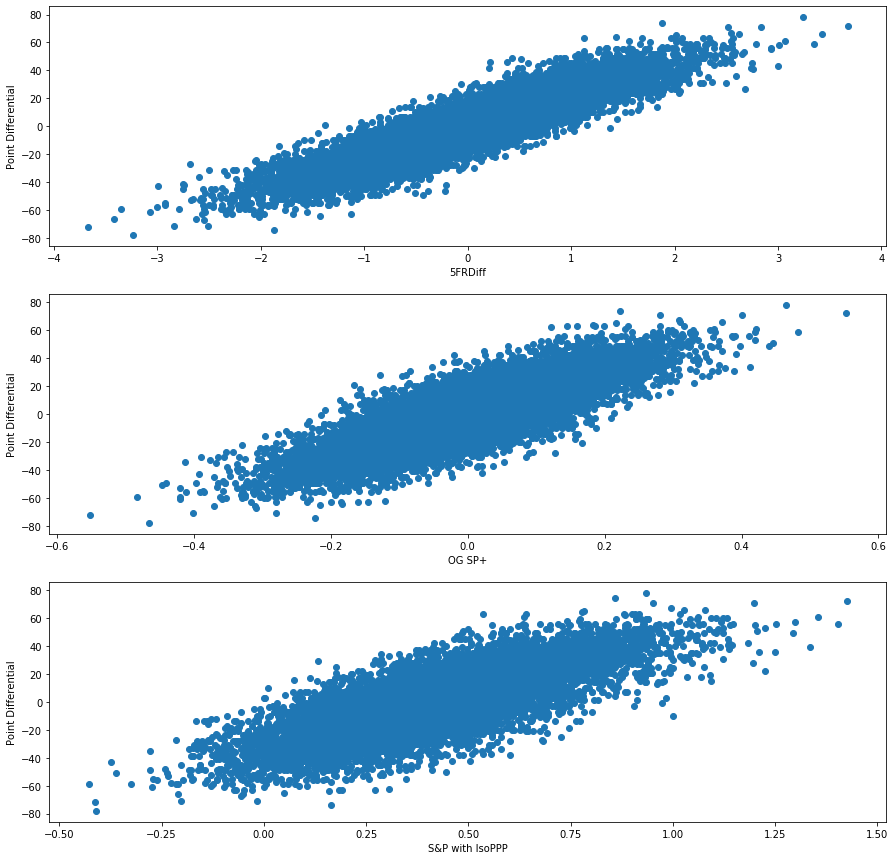

In [16]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [17]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.911982,0.759438
S&PIsoPPPDiff,0.911982,1.000000,0.816783
PtsDiff,0.759438,0.816783,1.000000


In [18]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813,1.037219,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037219,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104,0.474276,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104,0.474276,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776,0.583586,0.499553


In [19]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [20]:
# outliers

In [21]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813,1.037219,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037219,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104,0.474276,0.181656
5,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,-0.010417,0.416667,0.541667,0.095238,0.095238,0.750000,5.255388,0.510776,0.583586,0.499553
7,Rice,2012,322430242,24.0,-25.0,0.638687,0.423077,0.089744,5.141026,0.647310,...,-0.060758,-0.200000,-0.200000,-0.291667,-0.291667,-0.500000,4.618251,-0.763498,0.872332,1.135348


In [22]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [23]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 22.53134x + 0.07459
Mean Pred Score: -0.09022046024737729
Pred Std Dev: 19.318067593672488
Mean Abs Error: 7.670527442277177
Mdn Abs Error: 6.175130052616668
R-squared: 0.8059188715057745



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.761883,0.579894,0.500744,0.802712,0.604774,0.600563,0.983469,0.504200,0.779794,...,0.541349,0.474718,0.238197,0.202227,0.073152,0.140463,0.150953,0.898323,0.898323,0.898323
OffSRDiff,0.761883,1.000000,0.495525,0.296700,0.696766,0.403277,0.436034,0.760916,0.728473,0.720373,...,0.545946,0.427966,0.186890,0.155876,-0.019263,0.042169,0.070147,0.915585,0.915585,0.915585
OffERDiff,0.579894,0.495525,1.000000,0.160321,0.514801,0.311756,0.342415,0.572544,0.358842,0.817248,...,0.193998,0.210013,0.137431,0.085531,0.023512,0.063856,0.051579,0.536242,0.536242,0.536242
FPDiff,0.500744,0.296700,0.160321,1.000000,0.612054,0.114962,0.103066,0.475831,0.054270,0.243259,...,0.263046,0.285846,0.340122,0.279292,0.209182,0.227662,0.171724,0.572791,0.572791,0.572791
OppRateDiff,0.802712,0.696766,0.514801,0.612054,1.000000,0.213724,0.216087,0.803192,0.270534,0.674802,...,0.490831,0.436895,0.260066,0.232569,0.024950,0.098804,0.205907,0.827450,0.827450,0.827450
OppEffDiff,0.604774,0.403277,0.311756,0.114962,0.213724,1.000000,0.747154,0.595784,0.515126,0.439124,...,0.321357,0.265506,0.081269,0.063402,0.050273,0.078593,0.316785,0.496896,0.496896,0.496896
OppPPDDiff,0.600563,0.436034,0.342415,0.103066,0.216087,0.747154,1.000000,0.602760,0.550384,0.477657,...,0.355824,0.305174,0.055632,0.054888,0.049086,0.083823,0.016675,0.557859,0.557859,0.557859
PPDDiff,0.983469,0.760916,0.572544,0.475831,0.803192,0.595784,0.602760,1.000000,0.497156,0.769864,...,0.545173,0.474194,0.236193,0.199641,0.062433,0.139870,0.141075,0.890997,0.890997,0.890997
OppSRDiff,0.504200,0.728473,0.358842,0.054270,0.270534,0.515126,0.550384,0.497156,1.000000,0.527652,...,0.373320,0.274571,0.094624,0.063452,-0.010270,0.014489,-0.050622,0.649726,0.649726,0.649726
YPPDiff,0.779794,0.720373,0.817248,0.243259,0.674802,0.439124,0.477657,0.769864,0.527652,1.000000,...,0.425741,0.411963,0.161273,0.116968,-0.012441,0.045393,0.059804,0.761794,0.761794,0.761794


In [24]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.763787,0.761883,0.726650,0.902414,0.500744,0.507613,0.898323,0.898323,0.898323
ActPts,0.763787,1.000000,0.587730,0.552414,0.685370,0.372057,0.373329,0.683883,0.683883,0.683883
Eff,0.761883,0.587730,1.000000,0.655186,0.796881,0.296700,0.279645,0.915585,0.915585,0.915585
Expl,0.726650,0.552414,0.655186,1.000000,0.704076,0.231494,0.246605,0.706825,0.706825,0.706825
FinDrv,0.902414,0.685370,0.796881,0.704076,1.000000,0.436891,0.441904,0.924231,0.924231,0.924231
FldPos,0.500744,0.372057,0.296700,0.231494,0.436891,1.000000,0.365306,0.572791,0.572791,0.572791
Trnovr,0.507613,0.373329,0.279645,0.246605,0.441904,0.365306,1.000000,0.495238,0.495238,0.495238
5FR,0.898323,0.683883,0.915585,0.706825,0.924231,0.572791,0.495238,1.000000,1.000000,1.000000
5FRDiff,0.898323,0.683883,0.915585,0.706825,0.924231,0.572791,0.495238,1.000000,1.000000,1.000000
PredPtsDiff,0.898323,0.683883,0.915585,0.706825,0.924231,0.572791,0.495238,1.000000,1.000000,1.000000


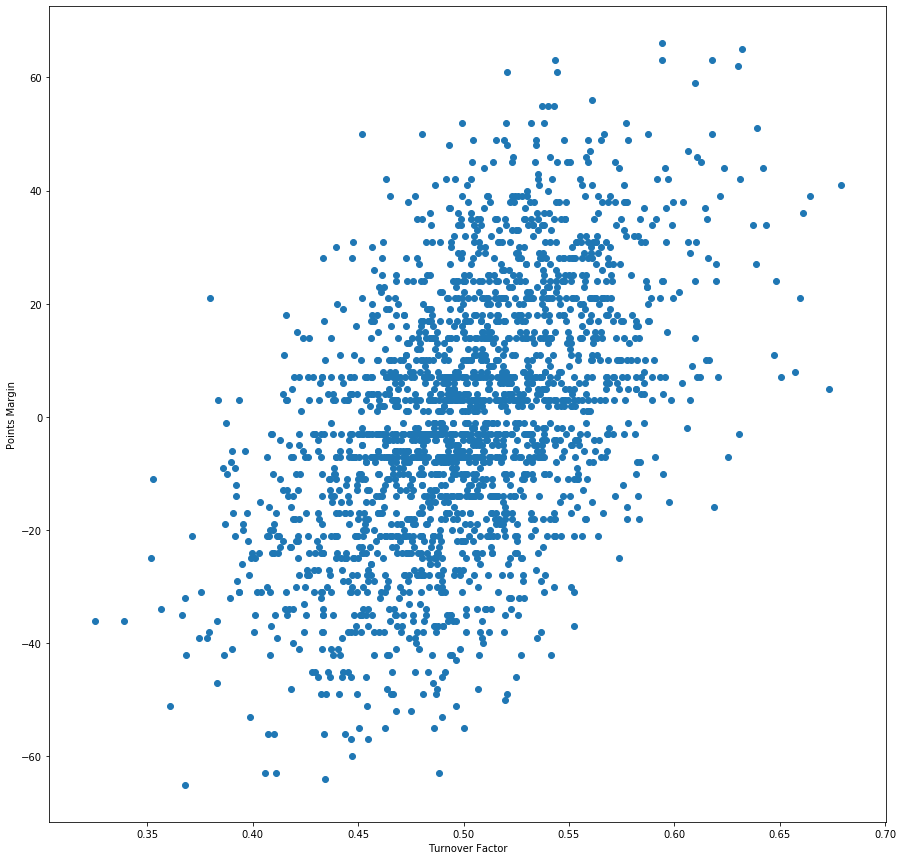

In [25]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

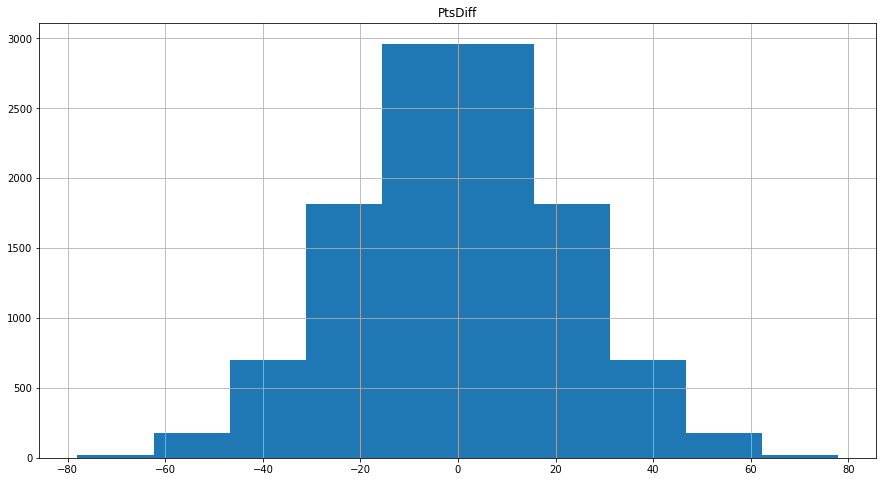

In [26]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

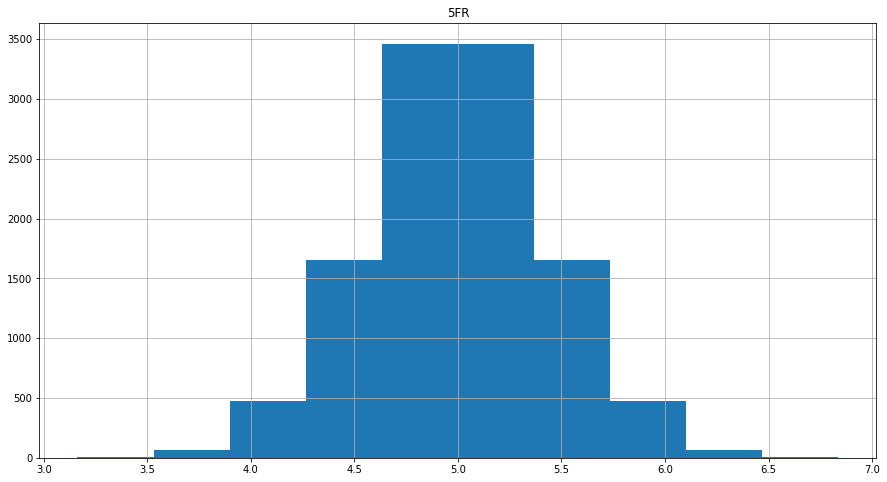

In [27]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

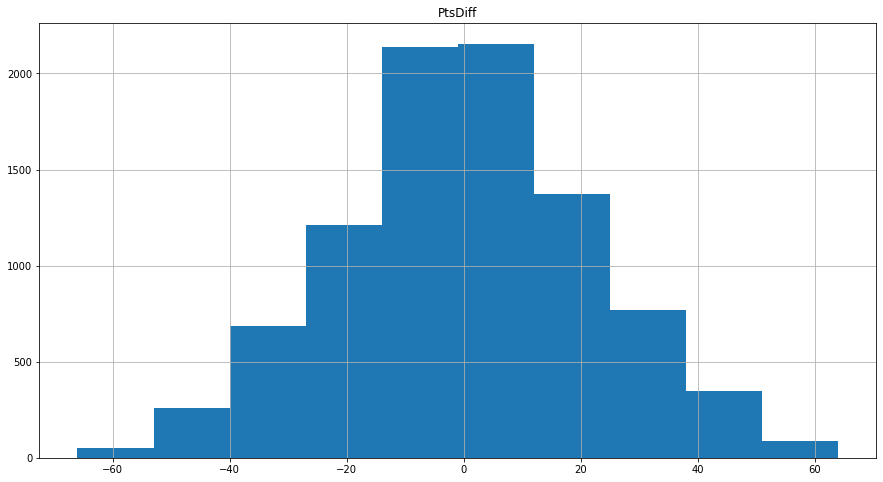

In [28]:
train_data.hist(column='PtsDiff', figsize=(15,8));

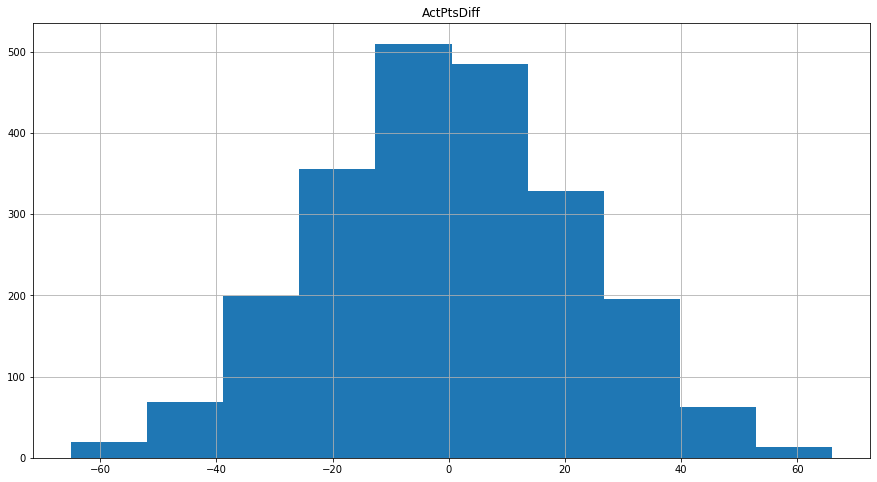

In [29]:
test.hist(column='ActPtsDiff', figsize=(15,8));

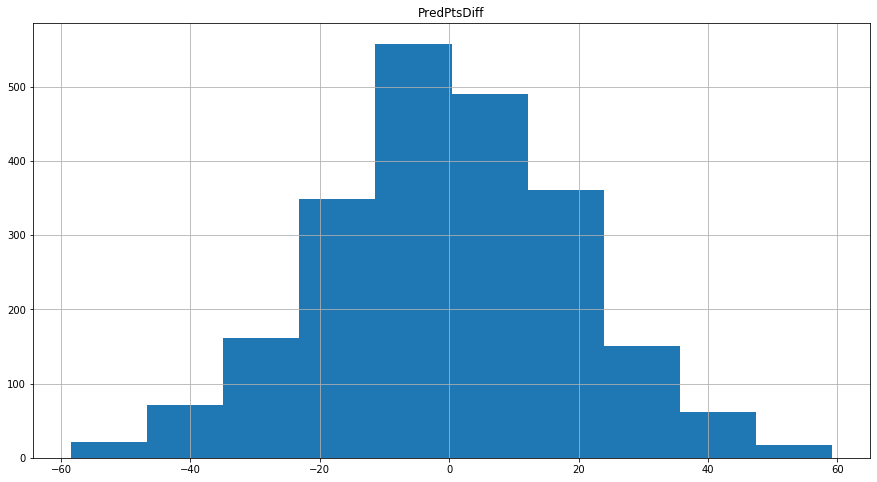

In [30]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [31]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [32]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -3.0 (exact value: -3.105406330329813)
Z score: -0.15608113262167284
Win Prob for Virginia Tech: 43.80%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [33]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -11.0 (exact value: -11.168436162040347)
Z score: -0.5734639682812566
Win Prob for Georgia Tech: 28.32%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,-0.121075,0.018689,0.000768,0.0,0.0,0.166667,0.166667,0.0,4.750502,-0.498995
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,0.121075,-0.018689,-0.000768,0.0,0.0,-0.166667,-0.166667,0.0,5.249498,0.498995


In [34]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -0.0 (exact value: -0.49389069628629395)
Z score: -0.02089599459581228
Win Prob for Georgia Tech: 49.17%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.300725,0.012719,0.0,-0.133333,0.066667,0.0,0.0,1.0,5.012615,0.025231
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.300725,-0.012719,0.0,0.133333,-0.066667,0.0,0.0,-1.0,4.987385,-0.025231


In [35]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 4.0 (exact value: 3.57790427192599)
Z score: 0.18988052062592628
Win Prob for Mississippi State: 57.53%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.070423,5.563380,0.880173,...,0.092249,0.000243,-0.004614,-0.666667,-0.333333,0.0,0.0,0,4.922257,-0.155486
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,-0.092249,-0.000243,0.004614,0.666667,0.333333,0.0,0.0,0,5.077743,0.155486


In [36]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -5.0 (exact value: -4.880670714609417)
Z score: -0.2479777147032616
Win Prob for Texas A&M: 40.21%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,-0.349878,0.001282,-0.047436,0.2,0.2,-0.25,-0.25,-0.25,5.109964,0.219927
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,0.349878,-0.001282,0.047436,-0.2,-0.2,0.25,0.25,0.25,4.890036,-0.219927


In [37]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.945346,13,12.0,1.0
2,Clemson,0.938931,13,12.0,1.0
3,Alabama,0.915813,12,11.0,1.0
4,LSU,0.914302,13,12.0,1.0
5,Wisconsin,0.878844,13,11.0,2.0
6,Utah,0.849827,13,11.0,2.0
7,Oklahoma,0.832738,13,11.0,2.0
8,Oregon,0.819448,13,11.0,2.0
9,Appalachian State,0.804431,13,10.0,3.0
10,Georgia,0.796488,13,10.0,3.0


In [38]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.561676,1.438324
21,Clemson,10.648286,2.351714
53,LSU,10.441241,2.558759
128,Wisconsin,9.677862,3.322138
2,Alabama,9.343552,2.656448
115,Utah,9.215906,3.784094
78,Oklahoma,9.125825,3.874175
3,Appalachian State,8.806627,4.193373
82,Oregon,8.798886,4.201114
34,Georgia,8.585330,4.414670


In [39]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.557889,1
1,Florida State,2012,5.454605,2
2,BYU,2012,5.335653,3
3,Arizona State,2012,5.333539,4
4,Oklahoma,2012,5.331083,5
5,Fresno State,2012,5.309021,6
6,Georgia,2012,5.304040,7
7,Notre Dame,2012,5.289858,8
8,Utah State,2012,5.267835,9
9,Kansas State,2012,5.266560,10


In [40]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323080349.0,Army,2012.0,Air Force,8.0
8,323150021.0,San Diego State,2012.0,Air Force,9.0
9,323212005.0,Hawai'i,2012.0,Air Force,10.0


In [41]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
        
#     print(grouped_by_year.get_group((team1, year))[:1].tail(4))
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.1465354438097139, -20.401406232975823]

In [72]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
#     ['North Carolina','Temple',5], # UNC 55, Temple 13
#     ['Michigan State','Wake Forest',3.5], # MichSt 27, Wake 21
#     ['Texas A&M', 'Oklahoma State', 7], # TAMU 24, OKST 21
#     ['Iowa', 'USC', 2.5], # Iowa 48, USC 24
#     ['Air Force', 'Washington State', 3], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
#     ['Penn State','Memphis',7], # Cotton Bowl - PennSt 53, Memphis 39
#     ['Notre Dame', 'Iowa State', 4], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
#     ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
#     ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
#     ['Western Kentucky', 'Western Michigan', 3.5], # WKU 23, WMU 20
#     ['Mississippi State', 'Louisville', 4], # LOU 38, MSST 28
#     ['California', 'Illinois', 6.5], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
#     ['Florida','Virginia',14], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
    ['Virginia Tech', 'Kentucky', 3],
    ['Arizona State', 'Florida State', 4],
    ['Navy', 'Kansas State', 2],
    ['Wyoming', 'Georgia State', 7],
    ['Utah', 'Texas', 7],
    
    ['Auburn', 'Minnesota', 7.5],
    ['Alabama', 'Michigan', 7],
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5], # Sugar Bowl
    
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    
    ['Ohio', 'Nevada', 7.5],
    
    ['Tulane', 'Southern Mississippi', 7],
    
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Virginia Tech,Kentucky,3.0,4.844929,0.600819,True,Virginia Tech,Virginia Tech
0,Arizona State,Florida State,4.0,4.145876,0.586785,True,Arizona State,Arizona State
0,Navy,Kansas State,2.0,3.134076,0.566278,True,Navy,Navy
0,Wyoming,Georgia State,7.0,3.795664,0.579710,False,Wyoming,Georgia State
0,Utah,Texas,7.0,3.061123,0.564792,False,Utah,Texas
0,Auburn,Minnesota,7.5,0.015845,0.502190,False,Auburn,Minnesota
0,Alabama,Michigan,7.0,4.416424,0.592231,False,Alabama,Michigan
0,Wisconsin,Oregon,2.5,1.339250,0.529493,False,Wisconsin,Oregon
0,Georgia,Baylor,7.5,-2.778897,0.444654,False,Baylor,Baylor
0,Cincinnati,Boston College,7.0,-5.729534,0.385174,False,Boston College,Boston College


In [43]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 0.0 (exact value: 0.3495351245833897)
Z score: 0.022763953107546128
Win Prob for Virginia: 50.91%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-0.403644,-0.089435,-0.044717,0.25,0.125,0.333333,0.333333,0.0,4.993899,-0.012203
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,0.403644,0.089435,0.044717,-0.25,-0.125,-0.333333,-0.333333,0.0,5.006101,0.012203


In [44]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.51661533276245)
Z score: 0.5490629816661388
Win Prob for North Carolina: 70.85%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.235394,0.079888,0.037736,0.238095,0.380952,-0.214286,-0.214286,0.5,5.231722,0.463445
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.235394,-0.079888,-0.037736,-0.238095,-0.380952,0.214286,0.214286,-0.5,4.768278,-0.463445


In [45]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 19.0 (exact value: 18.970373251233852)
Z score: 0.9866718614093889
Win Prob for Pittsburgh: 83.81%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,-0.248736,0.038746,0.026324,0.0,0.0,0.0,0.0,0.166667,5.419322,0.838645
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,0.248736,-0.038746,-0.026324,0.0,0.0,0.0,0.0,-0.166667,4.580678,-0.838645


In [46]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -10.0 (exact value: -9.546852977784656)
Z score: -0.48952269535668985
Win Prob for Auburn: 31.22%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.083465,-0.033763,-0.013333,0.053571,0.160714,-0.666667,-0.666667,-0.5,5.213512,0.427025
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.083465,0.033763,0.013333,-0.053571,-0.160714,0.666667,0.666667,0.5,4.786488,-0.427025


In [61]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 34.0 (exact value: 33.978518923082156)
Z score: 1.7635687015863086
Win Prob for Georgia: 96.11%
---


,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,...,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff
0,0.248084,0.104406,9.75,0.455357,0.444444,2.666667,3.276786,-0.047059,4.45067,0.0,...,0.330151,25.998278,0.455922,0.020115,0.003352,0.888889,-0.111111,0.461538,0.461538,0.5
1,-0.248084,-0.104406,-9.75,-0.455357,-0.444444,-2.666667,-3.276786,0.047059,-4.45067,0.0,...,-0.330151,-25.998278,-0.455922,-0.020115,-0.003352,-0.888889,0.111111,-0.461538,-0.461538,-0.5


In [48]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 22.0 (exact value: 21.536494011518688)
Z score: 1.1195071332522804
Win Prob for Clemson: 86.85%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 10.0 (exact value: 9.507958461581074)
Z score: 0.4968498466674935
Win Prob for Georgia Tech: 69.04%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -10.0 (exact value: -10.368901659794847)
Z score: -0.5320760552113498
Win Prob for The Citadel: 29.73%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 21.0 (exact value: 20.77350326669853)
Z score: 1.080010908222502
Win Prob for Temple: 85.99%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.51661533276245)
Z score: 0.54906298166613

,GameID,Year,Team,Opponent,PredWinProb,PredMOV,ActualMOV,PostGameWinProb
0,401111653,2019,Georgia Tech,Clemson,19.162313,-16.753793,-38.0,13.146192
1,401112441,2019,Georgia Tech,South Florida,79.510284,15.832806,4.0,69.035253
2,401112452,2019,Georgia Tech,The Citadel,97.462031,37.647787,-3.0,70.266334
3,401112469,2019,Georgia Tech,Temple,40.258002,-4.675057,-22.0,14.006866
4,401112475,2019,Georgia Tech,North Carolina,52.714409,1.225199,-16.0,29.148111
5,401112480,2019,Georgia Tech,Duke,25.493356,-12.641248,-18.0,26.273617
6,401112488,2019,Georgia Tech,Miami,34.204558,-7.770046,7.0,28.316529
7,401112498,2019,Georgia Tech,Pittsburgh,34.622428,-7.731180,-10.0,16.190176
8,401112504,2019,Georgia Tech,Virginia,33.112566,-8.348046,-5.0,28.937828
9,401112511,2019,Georgia Tech,Virginia Tech,11.558530,-23.220688,-45.0,0.139655


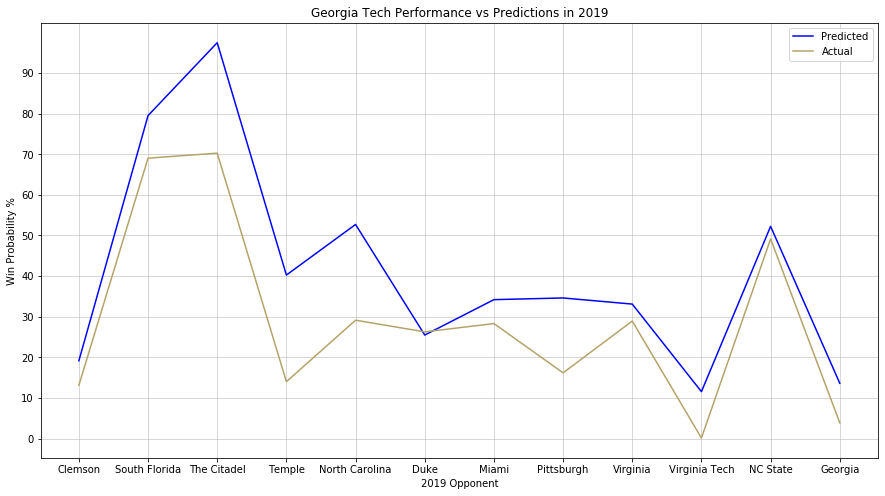

In [49]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

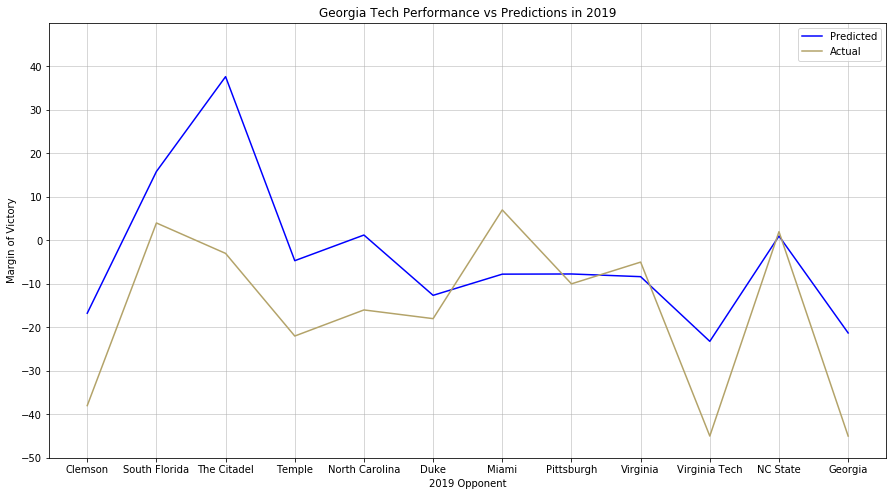

In [50]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 40.0 (exact value: 39.900483905381506)
Z score: 2.0701192897123724
Win Prob for Georgia Tech: 98.08%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 8.0 (exact value: 8.2841948548849)
Z score: 0.43350170893258827
Win Prob for South Florida: 66.77%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 7.0 (exact value: 7.181154964991086)
Z score: 0.37640283584162204
Win Prob for Pittsburgh: 64.67%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 35.0 (exact value: 34.53422968776712)
Z score: 1.792335075965648
Win Prob for Clemson: 96.35%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 38.0 (exact value: 38.21626674099486)
Z score:

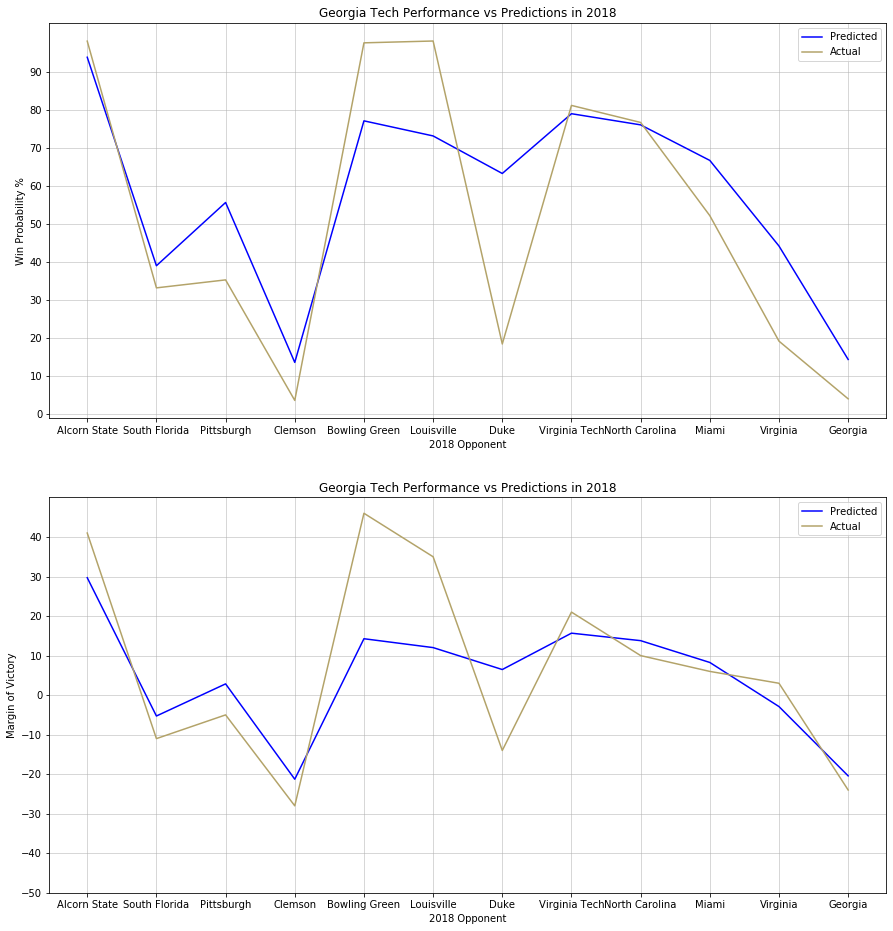

In [51]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

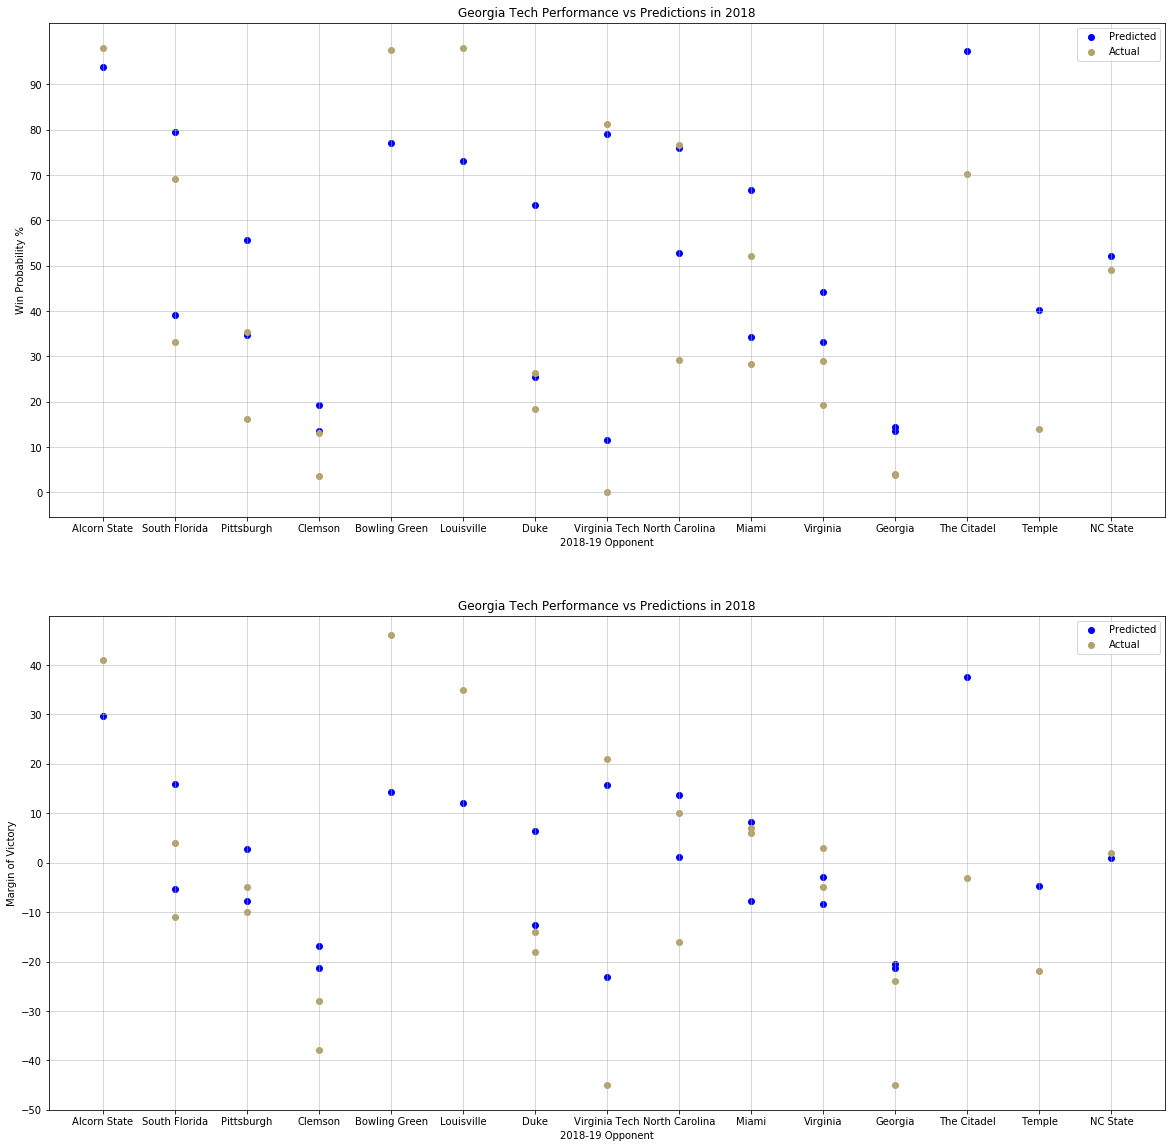

In [52]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [53]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.588419,0.525915,0.451663,0.382888,0.294898,0.300102,0.363730
2013,0.588419,1.000000,0.562651,0.366462,0.245886,0.260369,0.185906,0.279507
2014,0.525915,0.562651,1.000000,0.616098,0.486532,0.332827,0.332063,0.386230
2015,0.451663,0.366462,0.616098,1.000000,0.656853,0.472454,0.379344,0.403584
2016,0.382888,0.245886,0.486532,0.656853,1.000000,0.602837,0.417091,0.594324
2017,0.294898,0.260369,0.332827,0.472454,0.602837,1.000000,0.634993,0.569357
2018,0.300102,0.185906,0.332063,0.379344,0.417091,0.634993,1.000000,0.610011
2019,0.363730,0.279507,0.386230,0.403584,0.594324,0.569357,0.610011,1.000000


In [54]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["UCF","Auburn","James Madison","Connecticut","Boston College","Duke","Miami","Georgia Tech","NC State","Pittsburgh","Virginia Tech","Virginia"],
    "Site" : ["Away","Home","Home","Home","Away","Away","Away","Home","Home","Home","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("North Carolina", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,North Carolina,UCF,Away,37.171214,-6.413451
1,2020,North Carolina,Auburn,Home,29.811364,-10.325582
2,2020,North Carolina,James Madison,Home,97.886239,39.140922
3,2020,North Carolina,Connecticut,Home,75.596464,13.304553
4,2020,North Carolina,Boston College,Away,46.514864,-1.779988
5,2020,North Carolina,Duke,Away,49.042594,-0.553872
6,2020,North Carolina,Miami,Away,38.090880,-5.945427
7,2020,North Carolina,Georgia Tech,Home,60.472062,5.040371
8,2020,North Carolina,NC State,Home,56.629517,3.134925
9,2020,North Carolina,Pittsburgh,Home,48.711478,-0.714273


In [73]:
generate_win_prob(401135282, 2019)
box2 = calculate_box_score(401135282, 2019)
# testDiffs = ["Team",'5FRDiff']
print(box2[["Team","FP","FPDiff"]])
break_down_box_score(box2)

Could not find basic game data for game_id 401135282 locally, checking CFB Data API
Could not find drive data for game_id 401135282 locally, checking CFB Data API
Could not find play by play data for game_id 401135282 locally, checking CFB Data API
Game: Florida @ Virginia
Actual Winner: Florida
MOV: Florida by 8
Proj MOV: Florida by -5.0 (exact value: -5.418167246713233)
Z score: -0.2758012291152243
Win Prob for Florida: 39.14%
---
Could not find basic game data for game_id 401135282 locally, checking CFB Data API
Could not find drive data for game_id 401135282 locally, checking CFB Data API
Could not find play by play data for game_id 401135282 locally, checking CFB Data API
       Team         FP    FPDiff
0   Florida  22.250000 -7.204545
1  Virginia  29.454545  7.204545


,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Florida,4.872312,4.998002,4.970375,4.279545,4.99888,4.878109,-0.243783
1,Virginia,5.127688,5.001998,5.029625,5.720455,5.00112,5.121891,0.243783


In [58]:
predict_matchup("Oregon","Wisconsin", 2012, -1)

[0.41567415266483343, -4.204440263501043]

In [57]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)